<a href="https://colab.research.google.com/github/aldo-arevalo/Glucose-Insulin-MIMIC-III/blob/master/insulin_glucose_pairing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data extraction and Pairing of Insulin Inputs to Glucose Measurements in the ICU
## Interactive notebook

Authors: [Aldo Robles Arévalo](mailto:aldo.arevalo@tecnico.ulisboa.pt); Lawrence Baker; Susana M. da Silva Vieira; João M. da Costa Sousa; Stan Finkelstein; Jesse D. Raffa; Roselyn Cristelle; Leo Celi; Francis DeMichele

## Overview

This notebook contains the curation and pre-processing steps to extract glucose readings and insulin inputs from  the Medical Information Mart for Intensive Care (MIMIC). Moreover, it contains the code to pair a preceding glucose reading with a bolus of regular insulin.

# Code - Data Extraction



## Import dependencies and libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import warnings
import time
from datetime import datetime
from scipy import stats
from sklearn.metrics import mean_squared_error,r2_score

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing data using Google BigQuery.
from google.cloud import bigquery
from google.colab import files, auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

# Function to submit query to BigQuery
def q(query,projectid):
    client = bigquery.Client(location="US",project=projectid)
    # Location must match that of the dataset(s) referenced in the query.
    query_job = client.query(query,
    location="US",)  # API
    return query_job.to_dataframe()

# Rounding (for heatmap categories)
def myround(x, base):
    return int(base * round(float(x)/base))

def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col])
    
    return(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authenticated


In [0]:
# In case you prefer to save the dataframes in your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# Specify the path to your own folder
base_dir = "/content/gdrive/My Drive/Insulin Therapy ICU"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Verify client name


In [0]:
projectid = "hst-953-2019"
client = bigquery.Client(location="US",project=projectid)
print("Client creating using default project: {}".format(client.project))

Client creating using default project: hst-953-2019


### Extraction of insulin events

The following item id's are extracted

| Item id | Insulin type |
|---------|:------------:|
| 223257  |'Intermediate'|
| 223258  |   'Short'    |
| 223259  |'Intermediate'|
| 223260  |   'Long'     |
| 223261  |'Intermediate'|
| 223262  |   'Short'    |

In [0]:
# Import Insulin inputs - raw

query="""
SELECT atr.SUBJECT_ID, atr.HADM_ID, atr.ICUSTAY_ID
    , CAST(atr.starttime AS TIMESTAMP) AS STARTTIME
    , CAST(atr.endtime AS TIMESTAMP) AS ENDTIME
    , atr.AMOUNT, atr.RATE, atr.ORIGINALRATE, atr.ITEMID, atr.ORDERCATEGORYNAME
    , (CASE
        WHEN itemid=223257 THEN 'Intermediate' --'Ins7030'
        WHEN itemid=223258 THEN 'Short'        --'InsRegular'
        WHEN itemid=223259 THEN 'Intermediate' --'InsNPH'
        WHEN itemid=223260 THEN 'Long'         --'InsGlargine'
        WHEN itemid=223261 THEN 'Intermediate' --'InsHum7525'
        WHEN itemid=223262 THEN 'Short'        --'InsHum'
        ELSE null END) AS InsulinType
    , (CASE
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%NON IV%' THEN 'BOLUS_INYECTION'
        WHEN UPPER(ORDERCATEGORYNAME) LIKE '%MED BOLUS%' THEN 'BOLUS_PUSH'
        WHEN ORDERCATEGORYNAME IN ('01-Drips','12-Parenteral Nutrition') THEN 'INFUSION'
        ELSE null END) AS InsulinAdmin
    , (CASE WHEN STATUSDESCRIPTION IN ('Paused','Stopped') THEN 1 ELSE 0 END) AS INFXSTOP
FROM `physionet-data.mimiciii_clinical.inputevents_mv` atr								
WHERE itemid IN (223257   -- [Ins7030]     - Insulin 70/30 
                , 223258  -- [InsRegular]  - Insulin Regular
                , 223259  -- [InsNPH]      - Insulin NPH
                , 223260  -- [InsGlargine] - Insulin Glargine
                , 223261  -- [nsHum7525]   - Insulin Humalog 75/25
                , 223262) -- [InsHum]      - Insulin Humalog
    AND atr.statusdescription != 'Rewritten' --Exclude invalid measures that were rewritten
GROUP BY atr.subject_id, atr.hadm_id, atr.icustay_id, atr.starttime
    , atr.endtime, atr.ITEMID, atr.ordercategoryname
    , atr.statusdescription, atr.amount, atr.rate, atr.ORIGINALRATE
ORDER BY atr.icustay_id, atr.subject_id, atr.hadm_id, atr.starttime
"""

insulin_mv = q(query,projectid)

display(insulin_mv.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
0,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 12:30:00+00:00,2.000000,NaN,2.0,223258,05-Med Bolus,Short,BOLUS_PUSH,0
1,963,190225,NaN,2204-10-26 12:29:00+00:00,2204-10-26 13:54:00+00:00,2.833333,2.000000,2.0,223258,01-Drips,Short,INFUSION,0
2,963,190225,NaN,2204-10-26 13:54:00+00:00,2204-10-26 16:08:00+00:00,6.701149,3.000515,3.0,223258,01-Drips,Short,INFUSION,0
3,963,190225,NaN,2204-10-26 16:08:00+00:00,2204-10-26 18:11:00+00:00,2.050352,1.000171,1.0,223258,01-Drips,Short,INFUSION,0
4,963,190225,NaN,2204-10-26 18:11:00+00:00,2204-10-26 19:07:00+00:00,1.866987,2.000343,2.0,223258,01-Drips,Short,INFUSION,0


In [0]:
# Coerse columns
insulin_mv[["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]] = insulin_mv[
        ["ICUSTAY_ID","INFXSTOP","RATE","ORIGINALRATE"]].apply(pd.to_numeric
        , errors='coerce')

boluses_raw = insulin_mv[(insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
boluses_intravenous_raw = insulin_mv[(insulin_mv['InsulinAdmin']=='BOLUS_PUSH')].shape[0]
boluses_subcutaneous_raw = insulin_mv[(insulin_mv['InsulinAdmin']=='BOLUS_INYECTION')].shape[0]
infusions_raw = insulin_mv[(insulin_mv['InsulinAdmin'] == 'INFUSION')].shape[0]
short_boluses_raw = insulin_mv[(insulin_mv['InsulinType']=="Short") &
                               (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
df_short_bol_raw = insulin_mv[(insulin_mv['InsulinType']=="Short") &
                               (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy()

# Save as CSV -- Uncomment as needed
#df_short_bol_raw.to_csv(base_dir+"BolusesRAW.csv", index=False, encoding='utf8', 
#                         header = True)

# Display results
display(HTML('<h4>It contains the following information</h4>'))
print("Entries: {}".format(insulin_mv.shape[0]))
print("Patients:            {}".format(insulin_mv['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(insulin_mv['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(insulin_mv['ICUSTAY_ID'].nunique()))
print('')
print('Boluses:              {}'.format(boluses_raw))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_raw))
print('Boluses intravenous:  {}'.format(boluses_intravenous_raw))
print('Infusions (regular):  {}'.format(infusions_raw))
print('Regular boluses:      {}'.format(short_boluses_raw))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(insulin_mv['ITEMID'].value_counts())

display(HTML('<h5>Verify column types</h5>'))
display(insulin_mv.dtypes)

# Entries: 151,201

Entries: 151201
Patients:            9638
Hospital admissions: 11236
ICU stays:           11882

Boluses:              105559
Boluses subcutaneous: 96204
Boluses intravenous:  9355
Infusions (regular):  45642
Regular boluses:      92936


223258    108237
223262     30341
223260      8641
223259      3383
223257       441
223261       158
Name: ITEMID, dtype: int64

SUBJECT_ID                         int64
HADM_ID                            int64
ICUSTAY_ID                       float64
STARTTIME            datetime64[ns, UTC]
ENDTIME              datetime64[ns, UTC]
AMOUNT                           float64
RATE                             float64
ORIGINALRATE                     float64
ITEMID                             int64
ORDERCATEGORYNAME                 object
InsulinType                       object
InsulinAdmin                      object
INFXSTOP                           int64
dtype: object

In [0]:
# Drop missing ICU stays
# Not taken in an ICU stay
insulin_mv = insulin_mv.dropna(subset=["ICUSTAY_ID"])

# Display results
display(HTML('<h5>It contains the following information</h5>'))
print("Entries: {}".format(insulin_mv.shape[0]))
print("Patients:            {}".format(insulin_mv['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(insulin_mv['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(insulin_mv['ICUSTAY_ID'].nunique()))

display(insulin_mv[['AMOUNT','RATE']].describe())

Entries: 151156
Patients:            9638
Hospital admissions: 11236
ICU stays:           11882


,AMOUNT,RATE
count,151156.000000,44632.000000
mean,7.818743,5.663981
std,10.977985,12.097432
min,0.000000,0.049999
25%,2.000000,2.001075
50%,4.000000,4.000000
75%,8.557214,6.034062
max,500.000015,1084.031880


#### Extraction of infusions
Only infusions of short-acting exist in MIMIC.

In [0]:
# Filter infusions (Regular insulin)
MV_infusions = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('INFUSION'))].copy(deep=True)

display(MV_infusions.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
118,74282,121149,200061.0,2134-01-23 23:08:00+00:00,2134-01-24 00:00:00+00:00,0.866667,1.000000,1.0,223258,01-Drips,Short,INFUSION,0
119,74282,121149,200061.0,2134-01-24 00:00:00+00:00,2134-01-24 01:00:00+00:00,2.000000,2.000000,2.0,223258,01-Drips,Short,INFUSION,0
120,74282,121149,200061.0,2134-01-24 01:00:00+00:00,2134-01-24 02:01:00+00:00,3.049477,2.999485,3.0,223258,01-Drips,Short,INFUSION,0
121,74282,121149,200061.0,2134-01-24 02:01:00+00:00,2134-01-24 03:05:00+00:00,5.333363,5.000028,5.0,223258,01-Drips,Short,INFUSION,0
122,74282,121149,200061.0,2134-01-24 03:05:00+00:00,2134-01-24 04:02:00+00:00,6.647539,6.997410,7.0,223258,01-Drips,Short,INFUSION,0


In [0]:
# Display results
display(HTML('<h4>Display descriptive statistics for infusion rates</h4>'))
display(MV_infusions[['RATE']].describe())

display(HTML('<h5>Infusions contains the following information</h5>'))
print("Entries: {}".format(MV_infusions.shape[0]))
print("Patients:            {}".format(MV_infusions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_infusions['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_infusions['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())
print('Should only be one ITEM id')

,RATE
count,44632.000000
mean,5.663981
std,12.097432
min,0.049999
25%,2.001075
50%,4.000000
75%,6.034062
max,1084.031880


Entries: 45623
Patients:            3621
Hospital admissions: 3829
ICU stays:           3879


223258    45623
Name: ITEMID, dtype: int64

Should only be one ITEM id


##### RATE and ORIGINALRATE
This subsection:
1. Gathers the missing rates
2. Substantation of why *ORIGINALRATE* is not deviated from actual/measured rate and can be used to impute missing rates.

In [0]:
# Extract values that are NOT null
MV_infusion_notnull = MV_infusions.dropna(subset=['RATE']).copy(deep=True)
print("Null values: {}".format(MV_infusions.shape[0]-MV_infusion_notnull.shape[0]))

# Remove values > 2000 for plotting
df=MV_infusion_notnull[(MV_infusion_notnull.ORIGINALRATE < 2000)]

Null values: 991


223258    45623
Name: ITEMID, dtype: int64

'r^2: 1.000'

MSE: 0.014


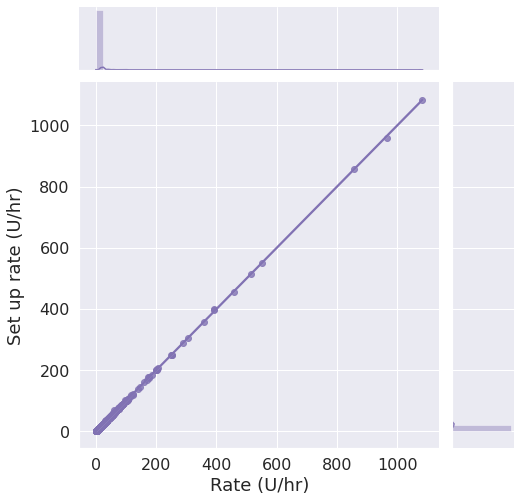

In [0]:
# JointPlot
sns.set(style="darkgrid", rc=None)

sns.jointplot(x='RATE', y='ORIGINALRATE', data=df, kind='reg', color = 'm', height=7)
plt.xlabel('Rate (U/hr)', fontsize=18)
plt.ylabel('Set up rate (U/hr)', fontsize = 18)
ax = plt.gca()
ax.tick_params(labelsize = 16)

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

# Correlation results
display(HTML('<h5>The correlation results are</h5>'))
display('r^2: {:.3f}'.format(r2_score(df.RATE, df.ORIGINALRATE)))
print('MSE: {:.3f}'.format(mean_squared_error(df.RATE, df.ORIGINALRATE)))

del df

In [0]:
# Replace missing rates with original rate
MV_infusions['RATE'].fillna(MV_infusions['ORIGINALRATE'], inplace=True)
print("Entries after replacing RATE by ORIGINALRATE: {}".format(MV_infusions.shape[0]))
display(MV_infusions[['RATE','ORIGINALRATE']].describe())

# Extract values that are NOT null
MV_infusions = MV_infusions.dropna(subset=['RATE'])
print("Entries after removing nulls:           {}".format(MV_infusions.shape[0]))

# Remove rates <= 0 U/hr
MV_infusions = MV_infusions[MV_infusions['RATE'] > 0]
print("Entries after removing rates <= 0 U/hr: {}".format(MV_infusions.shape[0]))

# Estimate 99th percentile for outlier removal
P99_infxn = MV_infusions['RATE'].quantile(.99)

# Drop boluses over 99th percentile
MV_infusions = MV_infusions[(MV_infusions['RATE'] < (MV_infusions['RATE'].quantile(.99)))]
print("Entries after removing inputs >99P:     {}".format(MV_infusions.shape[0]))

# Display results
display(HTML('<h4>Infusions of Short-acting insulin</h4>'))
display('P99: {:.3f}'.format(P99_infxn))

display(HTML('<h5>Descriptive statistics of administered doses</h5>'))
display(MV_infusions[['RATE']].describe())

display(HTML('<h5>Infusions of Short-acting insulin</h5>'))
print("Entries: {}".format(MV_infusions.shape[0]))
print("Patients:            {}".format(MV_infusions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_infusions['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_infusions['ICUSTAY_ID'].nunique()))

display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_infusions['ITEMID'].value_counts())

Entries after replacing RATE by ORIGINALRATE: 45623


,RATE,ORIGINALRATE
count,45623.000000,45623.000000
mean,5.541162,22.207227
std,11.993677,3561.058557
min,0.000000,0.000000
25%,2.000396,2.000000
50%,4.000000,4.000000
75%,6.011750,6.000000
max,1084.031880,760627.000000


Entries after removing nulls:           45623
Entries after removing rates <= 0 U/hr: 45088
Entries after removing inputs >99P:     44637


'P99: 29.816'

,RATE
count,44637.000000
mean,4.985555
std,4.164770
min,0.003418
25%,2.000681
50%,4.000000
75%,6.006266
max,29.812108


Entries: 44637
Patients:            3610
Hospital admissions: 3816
ICU stays:           3862


223258    44637
Name: ITEMID, dtype: int64

#### Extraction of boluses of short-acting insulin

In [0]:
# Filter short-acting boluses
MV_bol_short = insulin_mv[(insulin_mv['InsulinType']=="Short") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

display(MV_bol_short.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
45,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
46,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
47,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
49,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
51,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0


In [0]:
# Display results
display(HTML('<h4>Descriptive statistics for doses</h4>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Boluses of Short-acting insulin counts</h5>'))
print("Entries: {}".format(MV_bol_short.shape[0]))
print("Patients:            {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

,AMOUNT
count,92911.000000
mean,4.598449
std,4.240834
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,223.000000


Entries: 92911
Patients:            9496
Hospital admissions: 11029
ICU stays:           11652


In [0]:
 # Remove doses <= 0 U
MV_bol_short = MV_bol_short[MV_bol_short['AMOUNT'] > 0]
print("Entries after removing values < 0U: {}".format(MV_bol_short.shape[0]))

# Estimate 99th percentile for outlier removal
P99_bol_s = MV_bol_short['AMOUNT'].quantile(.99)

# Drop boluses over 99th percentile
display(HTML('<h5>99th percentile for boluses of regular insulin</h5>'))
display('P99: {:.2f}'.format(P99_bol_s))
MV_bol_short = MV_bol_short[(MV_bol_short['AMOUNT'] < (MV_bol_short['AMOUNT'].quantile(.99)))]
print("Entries after removing values > 99P: {}".format(MV_bol_short.shape[0]))

display(HTML('<h5>Descriptive statistics for boluses of regular insulin</h5>'))
display(MV_bol_short[['AMOUNT']].describe())

display(HTML('<h5>Boluses of short-acting contains the following updated information</h5>'))
print("Entries: {}".format(MV_bol_short.shape[0]))
print("Patients:            {}".format(MV_bol_short['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_bol_short['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_bol_short['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_short['ITEMID'].value_counts())

# Save CSV - Uncomment as needed
#MV_bol_short.to_csv(base_dir+"/DataExtraction/MV_bol_short.csv",index=False, encoding='utf8', header = True)

Entries after removing values < 0U: 89593


'P99: 18.00'

Entries after removing values > 99P: 88469


,AMOUNT
count,88469.000000
mean,4.517896
std,3.038117
min,0.100000
25%,2.000000
50%,4.000000
75%,6.000000
max,17.000000


Entries: 88469
Patients:            9370
Hospital admissions: 10877
ICU stays:           11484


223258    59847
223262    28622
Name: ITEMID, dtype: int64

#### Boluses of Intermediate-acting insulin

In [0]:
# Filter intermediate-acting insulin
MV_bol_inter = insulin_mv[(insulin_mv['InsulinType']=="Intermediate") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

print("Entries: {}".format(MV_bol_inter.shape[0]))
bol_inter_patients1 = MV_bol_inter['SUBJECT_ID'].unique()
display(MV_bol_inter.head())

Entries: 3982


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
248,50772,192069,200108.0,2110-12-10 18:00:00+00:00,2110-12-10 18:01:00+00:00,11.0,NaN,11.0,223257,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
848,69110,131817,200636.0,2123-02-08 13:17:00+00:00,2123-02-08 13:18:00+00:00,4.0,NaN,4.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1022,4588,186721,200746.0,2113-03-04 10:29:00+00:00,2113-03-04 10:30:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1190,70148,195958,200924.0,2173-11-19 22:31:00+00:00,2173-11-19 22:32:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0
1191,70148,195958,200924.0,2173-11-20 10:39:00+00:00,2173-11-20 10:40:00+00:00,10.0,NaN,10.0,223259,06-Insulin (Non IV),Intermediate,BOLUS_INYECTION,0


In [0]:
# Remove doses <= 0 U
MV_bol_inter = MV_bol_inter[MV_bol_inter['AMOUNT'] > 0]

# Display results
display(HTML('<h5>Descriptive statistics for boluses of intermediate insulin</h5>'))
display(MV_bol_inter[['AMOUNT']].describe())

display(HTML('<h5>Boluses of intermediate-acting ccounts</h5>'))
print("Entries: {}".format(MV_bol_inter.shape[0]))
print("Patients:            {}".format(MV_bol_inter['SUBJECT_ID'].nunique()))
bol_inter_patients2 = MV_bol_inter['SUBJECT_ID'].unique()
print("Hospital admissions: {}".format(MV_bol_inter['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_bol_inter['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_inter['ITEMID'].value_counts())

,AMOUNT
count,3962.000000
mean,18.572438
std,15.330288
min,1.000000
25%,8.000000
50%,15.000000
75%,25.000000
max,180.000000


Entries: 3962
Patients:            680
Hospital admissions: 781
ICU stays:           813


223259    3369
223257     437
223261     156
Name: ITEMID, dtype: int64

#### Boluses of Long-acting insulin

In [0]:
# Filter long-acting insulin boluses
MV_bol_long = insulin_mv[(insulin_mv['InsulinType']=="Long") & 
                      (insulin_mv['InsulinAdmin'].str.contains('BOLUS'))].copy(deep=True)

print("Entries: {}".format(MV_bol_long.shape[0]))
bol_long_patients1 = MV_bol_long['SUBJECT_ID'].unique()
display(MV_bol_long.head())

Entries: 8640


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
48,11861,192256,200010.0,2132-08-05 21:29:00+00:00,2132-08-05 21:30:00+00:00,20.0,NaN,20.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
50,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,40.0,NaN,40.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
56,41710,181955,200028.0,2133-10-30 22:21:00+00:00,2133-10-30 22:22:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
62,41710,181955,200028.0,2133-10-31 22:00:00+00:00,2133-10-31 22:01:00+00:00,66.0,NaN,66.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0
69,56369,198650,200033.0,2198-08-11 08:00:00+00:00,2198-08-11 08:01:00+00:00,10.0,NaN,10.0,223260,06-Insulin (Non IV),Long,BOLUS_INYECTION,0


In [0]:
# Remove doses <= 0 U
MV_bol_long = MV_bol_long[MV_bol_long['AMOUNT'] > 0]

display(HTML('<h5>Descriptive statistics for boluses of long-acting insulin</h5>'))
display(MV_bol_long[['AMOUNT']].describe())

display(HTML('<h5>Boluses of long-acting insulin counts</h5>'))
print("Entries: {}".format(MV_bol_long.shape[0]))
print("Patients:            {}".format(MV_bol_long['SUBJECT_ID'].nunique()))
bol_long_patients2 = MV_bol_long['SUBJECT_ID'].unique()
print("Hospital admissions: {}".format(MV_bol_long['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_bol_long['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_bol_long['ITEMID'].value_counts())

,AMOUNT
count,8626.000000
mean,23.377823
std,16.143641
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,180.000000


Entries: 8626
Patients:            2908
Hospital admissions: 3314
ICU stays:           3408


223260    8626
Name: ITEMID, dtype: int64

#### Merging boluses and infusions

In [0]:
frames = [MV_bol_short, MV_bol_inter, MV_infusions, MV_bol_long]
MV_insulin_step6 = pd.concat(frames, sort = True, verify_integrity=True
                             , ignore_index=True, axis = 0)
cols = list(MV_bol_short.columns)
MV_insulin_step6 = MV_insulin_step6[cols]

del frames, cols

# Display first lines
display(MV_insulin_step6.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,AMOUNT,RATE,ORIGINALRATE,ITEMID,ORDERCATEGORYNAME,InsulinType,InsulinAdmin,INFXSTOP
0,11861,192256,200010.0,2132-08-05 10:00:00+00:00,2132-08-05 10:01:00+00:00,4.0,NaN,4.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
1,11861,192256,200010.0,2132-08-05 16:12:00+00:00,2132-08-05 16:13:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
2,11861,192256,200010.0,2132-08-05 21:28:00+00:00,2132-08-05 21:29:00+00:00,8.0,NaN,8.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
3,76603,179633,200024.0,2127-03-03 17:30:00+00:00,2127-03-03 17:31:00+00:00,10.0,NaN,10.0,223258,06-Insulin (Non IV),Short,BOLUS_INYECTION,0
4,41710,181955,200028.0,2133-10-29 22:15:00+00:00,2133-10-29 22:16:00+00:00,6.0,NaN,6.0,223262,06-Insulin (Non IV),Short,BOLUS_INYECTION,0


In [0]:
# Display statistics
display(HTML('<h5>Descriptive statistics for all insulin doses</h5>'))
display(MV_insulin_step6[['AMOUNT','RATE']].describe())

boluses_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin'].str.contains('BOLUS'))].shape[0]
boluses_intravenous_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin']=='BOLUS_PUSH')].shape[0]
boluses_subcutaneous_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin']=='BOLUS_INYECTION')].shape[0]
infusions_cur = MV_insulin_step6[(MV_insulin_step6['InsulinAdmin'] == 'INFUSION')].shape[0]

# Display results
display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(MV_insulin_step6.shape[0]))
print("Patients:            {}".format(MV_insulin_step6['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(MV_insulin_step6['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(MV_insulin_step6['ICUSTAY_ID'].nunique()))
print('')
print('Boluses:              {}'.format(boluses_cur))
print('Boluses subcutaneous: {}'.format(boluses_subcutaneous_cur))
print('Boluses intravenous:  {}'.format(boluses_intravenous_cur))
print('Infusions:            {}'.format(infusions_cur))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(MV_insulin_step6['ITEMID'].value_counts())

# Administration route
display(HTML('<h5>Administration routes:</h5>'))
display(MV_insulin_step6['InsulinAdmin'].value_counts())

,AMOUNT,RATE
count,145694.000000,44637.000000
mean,7.635717,4.985555
std,9.840601,4.164770
min,0.000833,0.003418
25%,2.000000,2.000681
50%,4.000000,4.000000
75%,8.246813,6.006266
max,180.000000,29.812108


Entries: 145694
Patients:            9518
Hospital admissions: 11094
ICU stays:           11725

Boluses:              101057
Boluses subcutaneous: 91756
Boluses intravenous:  9301
Infusions:            44637


223258    104484
223262     28622
223260      8626
223259      3369
223257       437
223261       156
Name: ITEMID, dtype: int64

BOLUS_INYECTION    91756
INFUSION           44637
BOLUS_PUSH          9301
Name: InsulinAdmin, dtype: int64

### Glucose readings

The following item id's were identified:

| Item id | Description                 | Source    |
|:-------:|-----------------------------|:---------:|
| 807     |Fingerstick Glucose          |CHARTEVENTS|
| 811     | Glucose (70-105)            |CHARTEVENTS|
| 1529    | Glucose                     |CHARTEVENTS|
| 3745    | BloodGlucose                |CHARTEVENTS|
| 3744    | Blood Glucose               |CHARTEVENTS|
| 225664  | Glucose finger stick        |CHARTEVENTS|
| 220621  | Glucose (serum)             |CHARTEVENTS|
| 226537  | Glucose (whole blood)       |CHARTEVENTS|
| 50931   | GLUCOSE CHEMISTRY BLOOD     |LABEVENTS  |
| 50809   | GLUCOSE BLOOD GAS BLOOD)    |LABEVENTS  |

In [0]:
warnings.simplefilter('ignore')

# Import raw glucose readings
query="""
WITH chart AS(  -- Import data stored in CHARTEVENTS table
    SELECT ce.subject_id, ce.hadm_id, ce.icustay_id, ce.charttime, ce.storetime
    , (CASE
            WHEN itemid IN (811,1529,3745,3744,220621,226537,807,225664)
            AND ce.valuenum > 0 THEN valuenum            
            ELSE null END) AS Glu_Chart
    , ce.itemid, 1 AS idi
    FROM `physionet-data.mimiciii_clinical.chartevents` ce
    WHERE ce.itemid IN(807,     --  Fingerstick Glucose
                        811,    --	Glucose (70-105)
                        1529,   --	Glucose
                        3745,   --	BloodGlucose
                        3744,   --	Blood Glucose
                        225664, --	Glucose finger stick
                        220621, --	Glucose (serum)
                        226537  --	Glucose (whole blood)
                        )
    AND (ce.error IS null OR ce.error <> 1)
)
, labv AS( -- Import data stored in LABEVENTS table
    SELECT le.SUBJECT_ID, le.HADM_ID, le.CHARTTIME 
    , (CASE
            WHEN itemid IN (50809,50931) AND valuenum > 0
            THEN valuenum ELSE null END) AS Glu_Labv
    , itemid, 2 AS idi
    FROM `physionet-data.mimiciii_clinical.labevents` le	 
    WHERE le.itemid IN(50931     -- GLUCOSE | CHEMISTRY | BLOOD 
                        , 50809) -- GLUCOSE | BLOOD GAS | BLOOD)
)
-- Join both tables/sources

SELECT pt.SUBJECT_ID, pt.HADM_ID, pt.ICUSTAY_ID
    , CAST(pt.CHARTTIME AS TIMESTAMP) AS CHARTTIME
    , CAST(pt.STORETIME AS TIMESTAMP) AS STORETIME
    , pt.glucose
    , COALESCE(pt.CH, pt.LB) AS ITEM_GLC
FROM (
    -- Call the temporary table LABV
    SELECT subject_id, hadm_id, null AS icustay_id, charttime
    , null AS storetime, glu_labv AS glucose, itemid AS LB, null AS CH 
    FROM labv AS le

    UNION DISTINCT

    -- Call the temporary table CHART                    
    SELECT subject_id, hadm_id, icustay_id, charttime, storetime, Glu_Chart, null
    , itemid FROM chart as ce
) pt
WHERE pt.glucose IS NOT null
GROUP BY pt.subject_id,pt.hadm_id,pt.ICUSTAY_ID,pt.charttime,pt.STORETIME,glucose,pt.CH,pt.LB
ORDER BY subject_id,hadm_id,ICUSTAY_ID,charttime 
"""

Glucose = q(query,projectid)

del query

# Coerse columns
Glucose[["CHARTTIME","STORETIME"]] = Glucose[
    ["CHARTTIME","STORETIME"]].apply(pd.to_datetime, format='%Y%m%d %H:%M:%S')

# Display first rows
display(Glucose.head())

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,STORETIME,glucose,ITEM_GLC
0,2,163353.0,243653.0,2138-07-17 20:30:00+00:00,2138-07-17 22:07:00+00:00,72.0,3745
1,3,NaN,NaN,2101-10-04 15:24:00+00:00,NaT,121.0,50931
2,3,NaN,NaN,2101-10-05 06:00:00+00:00,NaT,116.0,50931
3,3,NaN,NaN,2101-10-06 05:45:00+00:00,NaT,94.0,50931
4,3,NaN,NaN,2101-10-07 04:30:00+00:00,NaT,92.0,50931


In [0]:
# Display information
display(HTML('<h5>Descriptive statistics of all glucose readings</h5>'))
display(Glucose[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose.shape[0]))
print("Patients:            {}".format(Glucose['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose['ITEM_GLC'].value_counts())

,glucose
count,2.508737e+06
mean,1.377641e+02
std,8.947669e+02
min,1.060000e-01
25%,1.030000e+02
50%,1.250000e+02
75%,1.550000e+02
max,9.999990e+05


Entries: 2508737
Patients:            41395
Hospital admissions: 53078
ICU stays:           54601


50931     748747
807       431010
811       374668
1529      283795
225664    246001
50809     196591
220621    154525
226537     70231
3745        2639
3744         530
Name: ITEM_GLC, dtype: int64

#### Item id's distributions


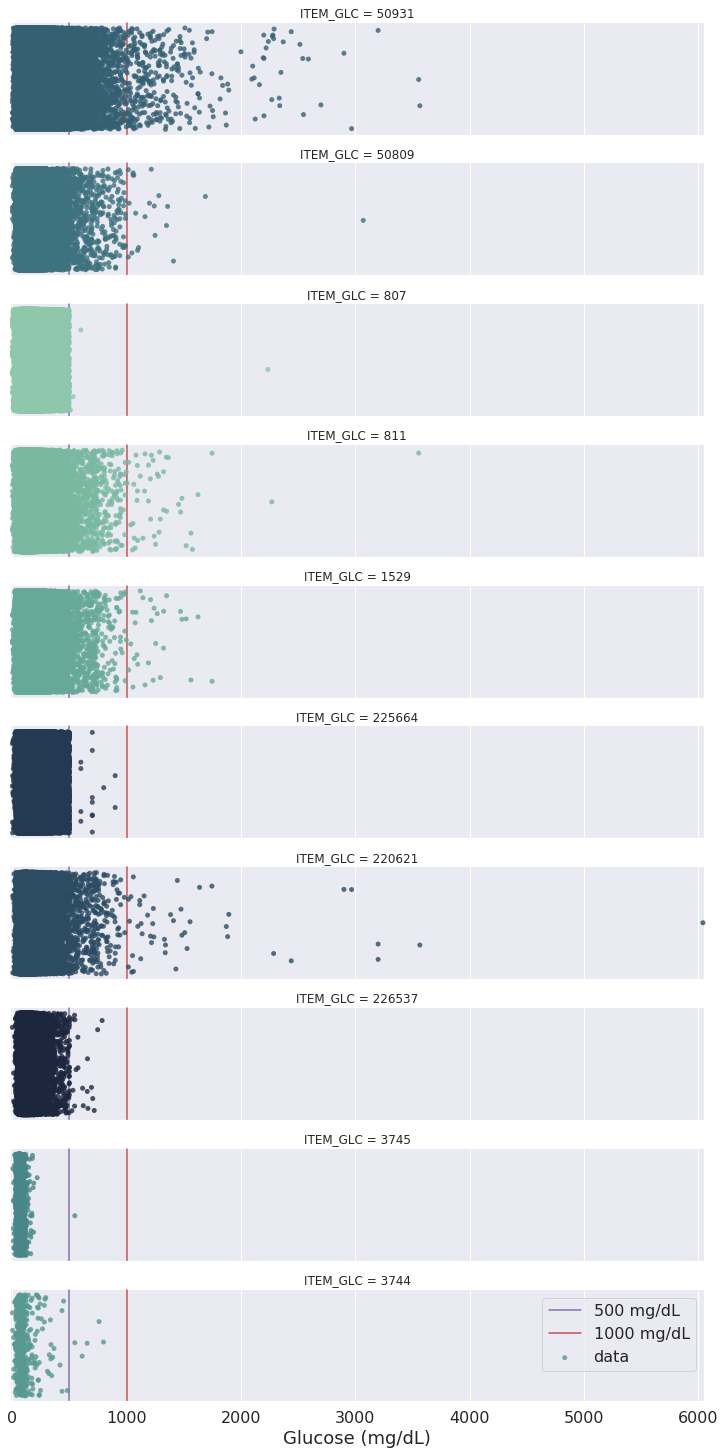

In [0]:
# Initialize the FacetGrid object
sns.set(style="darkgrid", rc=None)

# Plot
pal = sns.cubehelix_palette((Glucose['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose[Glucose.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, 
    row_order=[50931,50809,807,811,1529,225664,220621,226537,3745,3744], 
    height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose.glucose[Glucose.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

In [0]:
# Include patients that have insulin info
insulin_mv_patients = list(MV_insulin_step6.HADM_ID.dropna().unique())

Glucose_tmp = Glucose[Glucose['HADM_ID'].isin(insulin_mv_patients)].copy()

# Save CSV - Uncomment as needed
#Glucose_tmp[['SUBJECT_ID','ICUSTAY_ID','CHARTTIME','glucose']].to_csv(base_dir+"/DataExtraction/GlucoseRAW.csv", index=False, encoding='utf8', header = True)

,glucose
count,592561.000000
mean,150.957631
std,1838.141335
min,0.133000
25%,110.000000
50%,133.000000
75%,167.000000
max,999999.000000


'Raw for insulin patients: 295470.68'

'Raw for insulin patients: 543.21'

Readings (raw) per hospital stay: 53.41 +/- 64.01


Time lapse (hr) between raw readings/HADM stay: 3.57 +/- 4.86


Entries: 592561
Patients:            9518
Hospital admissions: 11094
ICU stays:           12224


225664    219065
50931     158781
220621     98046
226537     58425
50809      51078
1529        3020
811         3020
807         1126
Name: ITEM_GLC, dtype: int64

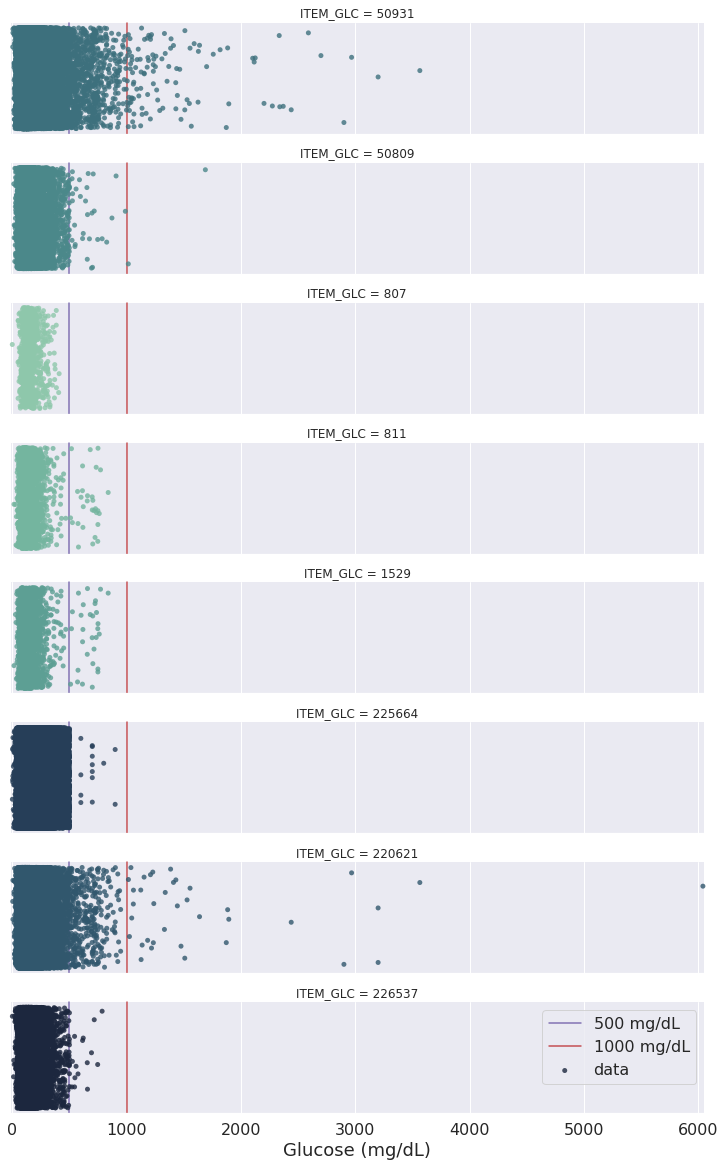

In [0]:
# Display statistics (updated)
display(HTML('<h4>Descriptive statistics of all glucose readings</h4>'))
display(Glucose_tmp[['glucose']].describe())

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h4>Excess Kurtosis</h4>'))
# positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates 
# a "light tailed" distribution.
display("Raw for insulin patients: {:.2f}".format(stats.kurtosis(Glucose_tmp['glucose'],
                                                                 axis=0, fisher=True, 
                                                                 bias=True, 
                                                                 nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h4>Fisher-Pearson coefficient of skewness</h4>'))
display("Raw for insulin patients: {:.2f}".format(stats.skew(Glucose_tmp['glucose'],
                                                             axis=0, bias=False, 
                                                             nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCraw = Glucose_tmp.groupby('HADM_ID').count().glucose.copy()

display(HTML('<h4>Readings per hospital stay<h4>'))
print("Readings (raw) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLCraw.mean(),
                                                                     countGLCraw.std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_both_raw = Glucose_tmp.copy(deep=True)
df_both_raw['diff'] = df_both_raw.sort_values(['HADM_ID',
                                               'CHARTTIME']).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_both_raw['diff_hr']= df_both_raw['diff'].dt.seconds/3600

display(HTML('<h4>Time lapse between readings<h4>'))
print("Time lapse (hr) between raw readings/HADM stay: {:0.2f} +/- {:0.2f}".format(
    df_both_raw['diff_hr'].mean(),df_both_raw['diff_hr'].std()))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose_tmp.shape[0]))
print("Patients:            {}".format(Glucose_tmp['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_tmp['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose_tmp['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose_tmp[Glucose_tmp.glucose < 9000], row="ITEM_GLC", 
                  hue="ITEM_GLC", aspect = 5, palette=pal,
                  row_order=[50931,50809,807,811,1529,225664,220621,226537],
                  height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_tmp.glucose[Glucose_tmp.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

,glucose
count,537155.000000
mean,151.983887
std,1930.510113
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999999.000000


Entries: 537155
Patients:            9518
Hospital admissions: 11094
ICU stays:           12224


225664    218977
50931     123026
220621     97644
226537     58376
50809      35170
811         1445
1529        1392
807         1125
Name: ITEM_GLC, dtype: int64

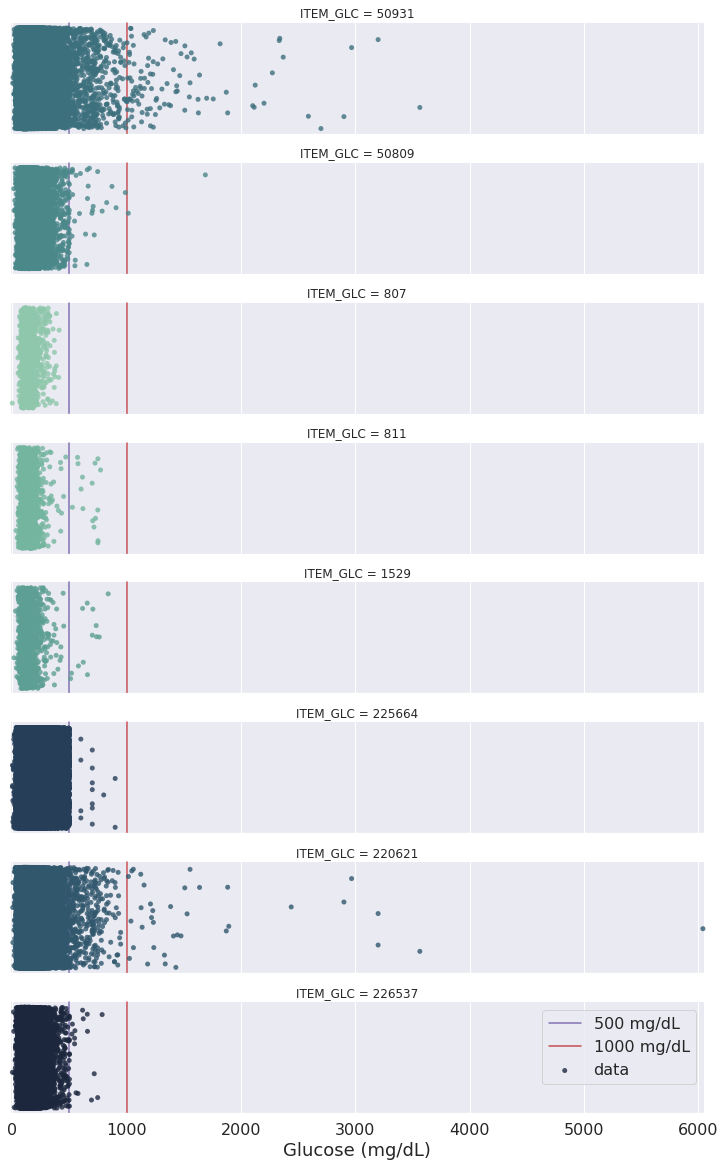

In [0]:
# Remove duplicated: same subject id, hadm id, and charttime
Glucose_tmp2 = Glucose_tmp.drop_duplicates(["SUBJECT_ID","HADM_ID","CHARTTIME",
                                   "glucose"], keep= 'last').copy(deep=True)
Glucose_tmp2['GLCSOURCE'] = np.nan

# Display information
display(HTML('<h5>Descriptive statistics for all glucose readings</h5>'))
display(Glucose_tmp2[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose_tmp2.shape[0]))
print("Patients:            {}".format(Glucose_tmp2['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_tmp2['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_tmp2['ICUSTAY_ID'].nunique()))

# Item id's
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_tmp2['ITEM_GLC'].value_counts())

# Plot
pal = sns.cubehelix_palette((Glucose_tmp2['ITEM_GLC'].nunique()), rot=-.4, 
                            light=.7)
g = sns.FacetGrid(Glucose_tmp2[Glucose_tmp2.glucose < 9000], 
                  row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal,
                  row_order=[50931,50809,807,811,1529,225664,220621,226537]
                  , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_tmp2.glucose[Glucose_tmp2.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

#### Fingerstick

In [0]:
# Filter fingerstick
Glucose_step3_finger = Glucose_tmp2[(Glucose_tmp2['ITEM_GLC'] == 807) | 
        (Glucose['ITEM_GLC'] == 225664) | (Glucose['ITEM_GLC'] == 226537) | 
        (Glucose['ITEM_GLC'] == 811) | (Glucose['ITEM_GLC'] == 1529) ]

# Display statistics (updated)
display(HTML('<h5>Descriptive Statistics for fingerstick glucose readings</h5>'))
display(Glucose_step3_finger[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_step3_finger.shape[0]))
print("Patients:            {}".format(Glucose_step3_finger['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_finger['ICUSTAY_ID'].nunique()))

,glucose
count,281315.000000
mean,155.150306
std,1886.161434
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,999999.000000


Entries: 281315
Patients:            9487
Hospital admissions: 11052
ICU stays:           12024


In [0]:
warnings.simplefilter('ignore')

# Remove values over 499
Glucose_step3_finger_sat = Glucose_step3_finger[(Glucose_step3_finger['glucose'] < 500)]

# Add flag column
Glucose_step3_finger_sat['GLCSOURCE'] = "FINGERSTICK"

# Display statistics (updated)
display(HTML('<h5>Descriptive statistics for cleaned fingerstick values</h5>'))
display(Glucose_step3_finger_sat[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose_step3_finger_sat.shape[0]))
print("Patients:            {}".format(Glucose_step3_finger_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_finger_sat['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_finger_sat['ICUSTAY_ID'].nunique()))

,glucose
count,281170.000000
mean,151.349437
std,59.325958
min,0.133000
25%,113.000000
50%,138.000000
75%,173.000000
max,499.000000


Entries: 281170
Patients:            9486
Hospital admissions: 11050
ICU stays:           12022


#### Laboratory samples

In [0]:
# Filter
Glucose_step3_blood = Glucose_tmp2[((Glucose_tmp2['ITEM_GLC'] == 3745) | 
        (Glucose_tmp2['ITEM_GLC'] == 220621) | (Glucose_tmp2['ITEM_GLC'] == 50931) | 
        (Glucose_tmp2['ITEM_GLC'] == 50809)
        )]

# Display information
display(HTML('<h5>Descriptive statistics for lab samples</h5>'))
display(Glucose_step3_blood[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose_step3_blood.shape[0]))
print("Patients:            {}".format(Glucose_step3_blood['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_blood['ICUSTAY_ID'].nunique()))

,glucose
count,255840.000000
mean,148.502176
std,1978.125235
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999999.000000


Entries: 255840
Patients:            9517
Hospital admissions: 11093
ICU stays:           12126


In [0]:
# Remove values over 1000
Glucose_step3_blood_sat = Glucose_step3_blood[(Glucose_step3_blood['glucose'] < 1000)]

# Add flag column
Glucose_step3_blood_sat['GLCSOURCE'] = "BLOOD"

# Display statistics (updated)
display(HTML('<h5>Descriptive statistics for cleaned lab samples</h5>'))
display(Glucose_step3_blood_sat[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(Glucose_step3_blood_sat.shape[0]))
print("Patients:            {}".format(Glucose_step3_blood_sat['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3_blood_sat['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3_blood_sat['ICUSTAY_ID'].nunique()))

,glucose
count,255696.000000
mean,143.832792
std,64.256563
min,4.000000
25%,107.000000
50%,129.000000
75%,162.000000
max,999.000000


Entries: 255696
Patients:            9517
Hospital admissions: 11093
ICU stays:           12126


#### Merging both sources

In [0]:
warnings.simplefilter('default')

Glucose_step3 = pd.concat([Glucose_step3_finger_sat, Glucose_step3_blood_sat]
, keys=['SUBJECT_ID', 'HADM_ID'], verify_integrity=True
, ignore_index=True)

# Display statistics (updated)
display(HTML('<h5>Statistics for all glucose readings</h5>'))
display(Glucose_step3[['glucose']].describe())

display(HTML('<h5>Counts for merged Glucose entries</h5>'))
print("Entries: {}".format(Glucose_step3.shape[0]))
print("Patients:            {}".format(Glucose_step3['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glucose_step3['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glucose_step3['ICUSTAY_ID'].nunique()))

,glucose
count,536866.000000
mean,147.769445
std,61.837426
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999.000000


Entries: 536866
Patients:            9518
Hospital admissions: 11094
ICU stays:           12224


#### Differences between fingerstick and lab analyzer

In [0]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
display(HTML('<h3>Excess Kurtosis</h3>'))
# positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates 
# a "light tailed" distribution.
display("Fingerstick:  {:.2f}".format(stats.kurtosis(Glucose_step3_finger_sat['glucose'],
                                                    axis=0, fisher=True, bias=True, 
                                                    nan_policy='omit')))
display("Lab Analyzer: {:.2f}".format(stats.kurtosis(Glucose_step3_blood_sat['glucose'],
                                                    axis=0, fisher=True, bias=True, 
                                                    nan_policy='omit')))
display("All together: {:.2f}".format(stats.kurtosis(Glucose_step3['glucose'],axis=0,
                                                    fisher=True, bias=True, 
                                                    nan_policy='omit')))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
countGLCfinger = Glucose_step3_finger_sat.groupby('HADM_ID').count().glucose.copy()

countGLClab = Glucose_step3_blood_sat.groupby('HADM_ID').count().glucose.copy()

countGLC = Glucose_step3.groupby('HADM_ID').count().glucose.copy()

display(HTML('<h3>Readings per hospital stay<h3>'))
print("Readings (fingerstick) per hospital stay:  {:0.2f} +/- {:0.2f}".format(countGLCfinger.mean(),
                                                                       countGLCfinger.std()))
print("Readings (lab analyzer) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLClab.mean(),
                                                                       countGLClab.std()))
print("Readings (both methods) per hospital stay: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                                       countGLC.std()))
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df_finger = Glucose_step3_finger_sat.copy(deep=True)
df_finger['diff'] = Glucose_step3_finger_sat.sort_values(['HADM_ID','CHARTTIME']
                                                        ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_finger['diff_hr']= df_finger['diff'].dt.seconds/3600

df_lab = Glucose_step3_blood_sat.copy(deep=True)
df_lab['diff'] = Glucose_step3_blood_sat.sort_values(['HADM_ID','CHARTTIME']
                                                    ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_lab['diff_hr']= df_lab['diff'].dt.seconds/3600

df_both = Glucose_step3.copy(deep=True)
df_both['diff'] = Glucose_step3.sort_values(['HADM_ID','CHARTTIME']
                                           ).groupby('HADM_ID')['CHARTTIME'].diff().copy()
df_both['diff_hr']= df_both['diff'].dt.seconds/3600

display(HTML('<h2>Time lapse between readings<h2>'))
print("Time lapse (hr) between bedside fingerstick readings/HADM stay: {:0.2f} +/- {:0.2f}".format(df_finger['diff_hr'].mean(),
                                                                                    df_finger['diff_hr'].std()))
print("Time lapse (hr) between lab analyzer readings/HADM stay:        {:0.2f} +/- {:0.2f}".format(df_lab['diff_hr'].mean(),
                                                                             df_lab['diff_hr'].std()))
print("Time lapse (hr) between both readings/HADM stay:                {:0.2f} +/- {:0.2f}".format(df_both['diff_hr'].mean(),
                                                                             df_both['diff_hr'].std()))

'Fingerstick:  4.85'

'Lab Analyzer: 23.65'

'All together: 15.02'

Readings (fingerstick) per hospital stay:  25.45 +/- 35.65
Readings (lab analyzer) per hospital stay: 23.05 +/- 27.51
Readings (both methods) per hospital stay: 48.39 +/- 58.04


Time lapse (hr) between bedside fingerstick readings/HADM stay: 4.32 +/- 3.85
Time lapse (hr) between lab analyzer readings/HADM stay:        7.07 +/- 7.72
Time lapse (hr) between both readings/HADM stay:                3.94 +/- 4.96


Text(0.5, 0, 'Δ time (hours)')

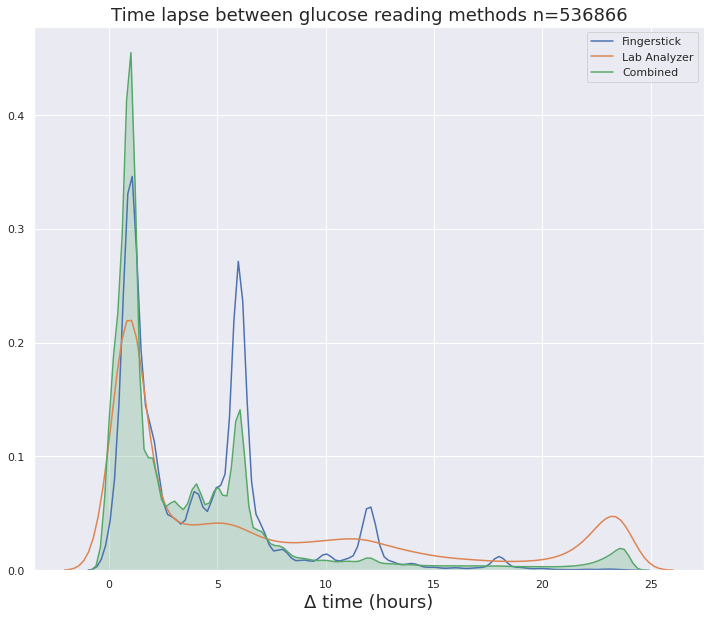

In [0]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot TIMEDELTA
plt.figure(figsize=(12,10))
plt.title('Time lapse between glucose reading methods n='+str(df_both.shape[0]),fontsize=18)
sns.kdeplot(df_finger['diff_hr'].dropna(), shade=False, label="Fingerstick")
sns.kdeplot(df_lab['diff_hr'].dropna(), shade=False, label="Lab Analyzer")
sns.kdeplot(df_both['diff_hr'].dropna(), shade=True, label="Combined")
plt.xlabel('\u0394 time (hours)', fontsize=18)

# Save to CSV - Uncomment as needed
#Glucose_step3_finger_sat.to_csv("GlucoseFingerS3.csv", index=False, encoding='utf8')
#Glucose_step3_blood_sat.to_csv("GlucoseBloodS3.csv", index=False, encoding='utf8')

#### CHARTTIME and STORETIME disadjustment

In [0]:
warnings.simplefilter('ignore')

# Find: (CASE WHEN pt.charttime < pt.storetime THEN pt.charttime ELSE pt.storetime END) AS timer_
Glucose['CHART_STORE'] = Glucose['CHARTTIME'] > Glucose['STORETIME']
Glucose_final = Glucose_step3.copy()
Glucose_final['CHART_STORE'] = Glucose_final['CHARTTIME'] > Glucose_final['STORETIME']

# Replace
Glucose_final.loc[(Glucose_final['CHART_STORE'] == True),'CHARTTIME'] = Glucose_final['STORETIME']

# Create subset for plotting
step4_switch_cases = Glucose_final[(Glucose_final.CHART_STORE == True)].copy()
step4_switch_cases['TIMEDELTA'] = abs(step4_switch_cases.CHARTTIME 
                  - step4_switch_cases.STORETIME).dt.seconds

# Display statistics
display(HTML('<h5>Descriptive statistics for all glucose readings that got switched their time stamps</h5>'))
display(step4_switch_cases[['glucose']].describe())

display(HTML('<h5>Counts</h5>'))
print("Entries: {}".format(step4_switch_cases.shape[0]))
print("Patients:            {}".format(step4_switch_cases['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(step4_switch_cases['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(step4_switch_cases['ICUSTAY_ID'].nunique()))

,glucose
count,44926.000000
mean,157.313605
std,60.772772
min,1.000000
25%,117.000000
50%,143.000000
75%,181.000000
max,498.000000


Entries: 44926
Patients:            7766
Hospital admissions: 8929
ICU stays:           9479


In [0]:
# Display statistics for Glucose curated
display(HTML('<h5>Descriptive statistics for all curated glucose readings</h5>'))
display(Glucose_final[['glucose']].describe())

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(Glucose_final.shape[0]))
print("Patients:             {}".format(Glucose_final['SUBJECT_ID'].nunique()))
print("Hospital admissions:  {}".format(Glucose_final['HADM_ID'].nunique()))
print('ICU stays:            {}'.format(Glucose_final['ICUSTAY_ID'].nunique()))
print("Readings per patient: {:0.2f} +/- {:0.2f}".format(countGLC.mean(),
                                                         countGLC.std()))

# Item id's
print("")
display(HTML('<h5>The gathered item ids are:</h5>'))
display(Glucose_final['ITEM_GLC'].value_counts())

,glucose
count,536866.000000
mean,147.769445
std,61.837426
min,0.133000
25%,110.000000
50%,134.000000
75%,168.000000
max,999.000000


Entries: 536866
Patients:             9518
Hospital admissions:  11094
ICU stays:            12224
Readings per patient: 48.39 +/- 58.04



225664    218885
50931     122922
220621     97606
226537     58352
50809      35168
811         1429
1529        1379
807         1125
Name: ITEM_GLC, dtype: int64

<Figure size 864x1440 with 0 Axes>

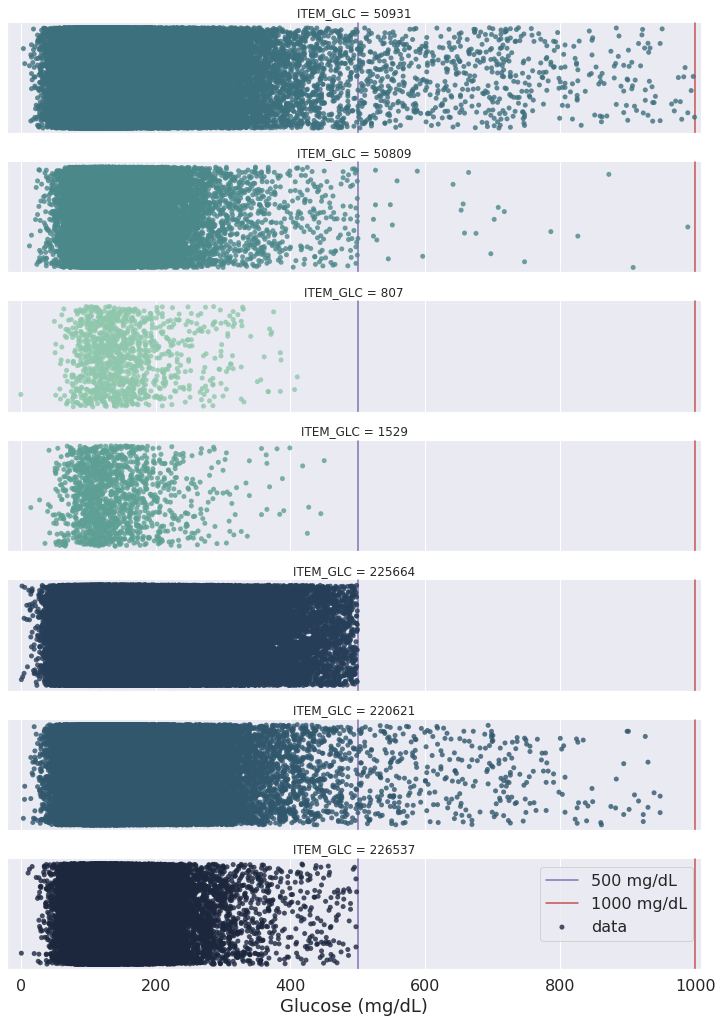

In [0]:
warnings.simplefilter('ignore')

# Plot
plt.figure(figsize=(12,20))
pal = sns.cubehelix_palette((Glucose_step3['ITEM_GLC'].nunique()), rot=-.4, light=.7)
g = sns.FacetGrid(Glucose_step3[Glucose_step3.glucose < 9000]
    , row="ITEM_GLC", hue="ITEM_GLC", aspect = 5, palette=pal, row_order=[50931,50809,807,1529
                                                                          ,225664,220621,226537]
                 , height = 2)
g.map(sns.stripplot, "glucose", clip_on=False, alpha=0.8, jitter=True)
g.map(plt.axvline, x=500, ymin=0, ymax=1, clip_on=False, color = 'm')
g.map(plt.axvline, x=1000, ymin=0, ymax=1, clip_on=False, color = 'r')
plt.xlabel('Glucose (mg/dL)', fontsize=18)
plt.xlim(-20,(max(Glucose_step3.glucose[Glucose_step3.glucose < 9000])+10))
ax = plt.gca()
ax.legend(['500 mg/dL','1000 mg/dL','data'],fontsize=16)
ax.tick_params(labelsize = 16)

## Curated datasets

In [0]:
warnings.simplefilter('ignore')

# Glucose readings (14 columns)
Glucose_cur = Glucose_final[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CHARTTIME'
                              ,'glucose','GLCSOURCE','CHART_STORE']].copy(deep=True)
Glucose_cur['STARTTIME'] = pd.NaT
Glucose_cur['ENDTIME'] = pd.NaT
Glucose_cur['INPUT'] = np.nan
Glucose_cur['INPUT_HRS'] = np.nan
Glucose_cur['INSULINTYPE'] = np.nan
Glucose_cur['EVENT'] = np.nan
Glucose_cur['INFXSTOP'] = np.nan

Glucose_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'GLCTIMER'
                         , 'GLC', 'GLCSOURCE','CHART_STORE', 'STARTTIME'
                         , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE'
                         , 'EVENT', 'INFXSTOP']

# Insulin events
Insulin_cur = MV_insulin_step6[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'
                               , 'STARTTIME', 'ENDTIME', 'AMOUNT', 'RATE'
                               , 'InsulinType', 'InsulinAdmin', 'INFXSTOP']].copy(deep=True)
Insulin_cur['GLCTIMER'] = pd.NaT
Insulin_cur['GLCSOURCE'] = np.nan
Insulin_cur['GLC'] = np.nan
Insulin_cur['CHART_STORE'] = np.nan

Insulin_cur.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'CHART_STORE', 'GLCTIMER'
                      , 'GLC','GLCSOURCE']

# Save to CSV
#Insulin_cur.to_csv(base_dir+"/DataExtraction/InsulinInputsCurated.csv", index=False, encoding='utf8')

In [0]:
# Concatenate subsets
warnings.simplefilter('default')

# Concatenate Glucose and insulin values
Glc_Ins = pd.concat([Insulin_cur, Glucose_cur], sort = True, ignore_index = True)

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME'
                      , 'ENDTIME', 'INPUT', 'INPUT_HRS', 'INSULINTYPE' 
                      , 'EVENT', 'INFXSTOP', 'GLCTIMER', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

Glc_Ins['TIMER'] = pd.NaT

# Reset index
Glc_Ins = Glc_Ins.reset_index()

# Reorder columns
Glc_Ins = Glc_Ins[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'TIMER' ,'STARTTIME'
                      , 'GLCTIMER', 'ENDTIME', 'INPUT', 'INPUT_HRS'
                      , 'INSULINTYPE', 'EVENT', 'GLC', 'GLCSOURCE'
                      , 'CHART_STORE', 'INFXSTOP']].sort_values(
                   by=['SUBJECT_ID', 'HADM_ID', 'GLCTIMER', 'STARTTIME'])

# Create a column that contains all timestamps ordered chronologically
Glc_Ins['TIMER'] = Glc_Ins['GLCTIMER']
Glc_Ins['TIMER'].loc[
        (Glc_Ins['TIMER'].isnull())] = Glc_Ins.loc[
                (Glc_Ins['TIMER'].isnull()),'STARTTIME']
Glc_Ins = Glc_Ins.sort_values(by = ['SUBJECT_ID', 'HADM_ID', 'TIMER'])

display(Glc_Ins.head())

display(HTML('<h4>Counts</h4>'))
print("Entries: {}".format(Glc_Ins.shape[0]))
print("Patients:            {}".format(Glc_Ins['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(Glc_Ins['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(Glc_Ins['ICUSTAY_ID'].nunique()))

# convert to datetime the columns that contain date and time data
time_cols = ['TIMER', 'STARTTIME', 'GLCTIMER', 'ENDTIME']

Glc_Ins = convert_to_datetime(Glc_Ins,time_cols)

# Save to CSV - Uncomment as needed
#Glc_Ins.to_csv(base_dir+"/DataExtraction/GlucoseInsulinUNIONALL.csv", index=False, encoding='utf8')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TIMER,STARTTIME,GLCTIMER,ENDTIME,INPUT,INPUT_HRS,INSULINTYPE,EVENT,GLC,GLCSOURCE,CHART_STORE,INFXSTOP
0,23,124321.0,NaN,2157-10-19 03:55:00+00:00,NaT,2157-10-19 03:55:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN
1,23,124321.0,NaN,2157-10-20 04:00:00+00:00,NaT,2157-10-20 04:00:00+00:00,NaT,NaN,NaN,NaN,NaN,167.0,BLOOD,False,NaN
2,23,124321.0,NaN,2157-10-21 03:40:00+00:00,NaT,2157-10-21 03:40:00+00:00,NaT,NaN,NaN,NaN,NaN,134.0,BLOOD,False,NaN
3,23,124321.0,NaN,2157-10-21 07:55:00+00:00,NaT,2157-10-21 07:55:00+00:00,NaT,NaN,NaN,NaN,NaN,122.0,BLOOD,False,NaN
4,23,124321.0,NaN,2157-10-21 10:27:00+00:00,NaT,2157-10-21 10:27:00+00:00,NaT,NaN,NaN,NaN,NaN,141.0,BLOOD,False,NaN


Entries: 682560
Patients:            9518
Hospital admissions: 11094
ICU stays:           12224


## INNER JOIN with ICU admissions

In [0]:
query="""
SELECT * FROM `physionet-data.mimiciii_derived.icustay_detail`
"""

admissions = q(query,projectid)

del query

admissions.rename(columns={"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID", 
                          "icustay_id": "ICUSTAY_ID", "intime": "ICU_ADMISSIONTIME", 
                          "outtime": "ICU_DISCHARGETIME", "los_icu": "LOS_ICU_days",
                          "first_icu_stay": "first_ICU_stay"},
                 inplace=True)

time_cols = ['admittime', 'dischtime', 'dod', 'ICU_ADMISSIONTIME', 'ICU_DISCHARGETIME']

admissions =  convert_to_datetime(admissions,time_cols)

display(HTML('<h4>ICU admissions<h4>'))
display("Column names: {}".format(list(admissions.columns)))

display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(admissions.shape[0]))
print('Columns: {}'.format(admissions.shape[1]))
print("Patients:            {}".format(admissions['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(admissions['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(admissions['ICUSTAY_ID'].nunique()))

"Column names: ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'gender', 'dod', 'admittime', 'dischtime', 'los_hospital', 'admission_age', 'ethnicity', 'admission_type', 'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'ICU_ADMISSIONTIME', 'ICU_DISCHARGETIME', 'LOS_ICU_days', 'icustay_seq', 'first_ICU_stay']"

Entries: 61051
Columns: 19
Patients:            46428
Hospital admissions: 57328
ICU stays:           61051


In [0]:
# Find duplicated HADM_ID, most likely because more than 1 ICU stay is associated
col_identifiers = ['SUBJECT_ID','HADM_ID' ,'ICUSTAY_ID']

df_unique_hospital = admissions[~admissions.duplicated(
    subset=['HADM_ID'], keep=False)].copy()

df_multi_hospital = admissions[admissions.duplicated(
    subset=['HADM_ID'], keep=False)].copy()

display(HTML('<h4>ICU admissions per hospital admission</h4>'))
print("Total of Hospital admissions: {}".format(admissions['HADM_ID'].nunique()))

display(HTML('<h4>Multiple ICU admissions per hospital admission</h4>'))
print('Hospital admissions with multiple ICU admissions: {}'.format(admissions.loc[
    admissions.duplicated(subset=['HADM_ID'],keep=False),['HADM_ID']].nunique().values))
print("Total entries for multiple ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_multi_hospital.shape[0], 
    df_multi_hospital.ICUSTAY_ID.nunique(), 
    df_multi_hospital.SUBJECT_ID.nunique()))

display(HTML('<h4>One ICU admission per hospital admission</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique_hospital.HADM_ID.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique_hospital.shape[0], 
    df_unique_hospital.ICUSTAY_ID.nunique(), 
    df_unique_hospital.SUBJECT_ID.nunique()))

Total of Hospital admissions: 57328


Hospital admissions with multiple ICU admissions: [3239]
Total entries for multiple ICU admissions: 6962, ICU stays: 6962, Patients: 3101


Hospital admissions with one ICU admission: 54089
Total entries for unique ICU admissions: 54089, ICU stays: 54089, Patients: 44412


In [0]:
# Inner join with hospital admissions with only one ICU admission
warnings.simplefilter("default")

# INNER JOIN
df_unique = df_unique_hospital[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID",
                                "ICU_ADMISSIONTIME","ICU_DISCHARGETIME",
                                "LOS_ICU_days","first_ICU_stay"]].merge(
    Glc_Ins[['SUBJECT_ID','HADM_ID','TIMER','STARTTIME','GLCTIMER','ENDTIME',
              'INPUT','INPUT_HRS','INSULINTYPE','EVENT','GLC','GLCSOURCE','INFXSTOP']],
    how='inner', on=["SUBJECT_ID", "HADM_ID"]).sort_values(by=['SUBJECT_ID',
                                                               'HADM_ID',
                                                               'TIMER'])

df_unique['GLCTIMER'] = pd.to_datetime(df_unique['GLCTIMER'], utc=True)
df_unique['ICU_ADMISSIONTIME'] = pd.to_datetime(df_unique['ICU_ADMISSIONTIME'], 
                                                utc=True)
df_unique['ICU_DISCHARGETIME'] = pd.to_datetime(df_unique['ICU_DISCHARGETIME'], 
                                                utc=True)
df_unique['ICU_ADMISSIONTIME'] = pd.to_datetime(df_unique['ICU_ADMISSIONTIME'], 
                                                utc=True)
df_unique['ENDTIME'] = pd.to_datetime(df_unique['ENDTIME'], utc=True)

display(HTML('<h4>One ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.HADM_ID.nunique()))
print("Total entries for unique ICU admissions: {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.ICUSTAY_ID.nunique(), 
    df_unique.SUBJECT_ID.nunique()))

# Drop measurements that occur before or after an ICU stay
df_unique = df_unique[(((df_unique["GLCTIMER"] > df_unique["ICU_ADMISSIONTIME"]) &
                        (df_unique["GLCTIMER"] < df_unique["ICU_DISCHARGETIME"])) |
                       ((df_unique["STARTTIME"] > df_unique["ICU_ADMISSIONTIME"]) &
                        (df_unique["ENDTIME"] < df_unique["ICU_DISCHARGETIME"])))]

display(HTML('<h4>One ICU admission per hospital admission + ICU glucose readings + ICU insulin inputs</h4>'))
print("Hospital admissions with one ICU admission: {}".format(
    df_unique.HADM_ID.nunique()))
print("Total entries for unique ICU admissions:    {}, ICU stays: {}, Patients: {}".format(
    df_unique.shape[0], 
    df_unique.ICUSTAY_ID.nunique(), 
    df_unique.SUBJECT_ID.nunique()))


Hospital admissions with one ICU admission: 10107
Total entries for unique ICU admissions: 572913, ICU stays: 10107, Patients: 8765


Hospital admissions with one ICU admission: 10107
Total entries for unique ICU admissions:    510916, ICU stays: 10107, Patients: 8765


In [0]:
# Inner join with hospital admissions with MULTIPLE ICU admissions

df_allids = df_multi_hospital[col_identifiers].drop_duplicates().copy()
HADM_list = df_multi_hospital['HADM_ID'].drop_duplicates().copy()

HADM_list = Glc_Ins.loc[Glc_Ins['HADM_ID'].isin(list(HADM_list)),
                        ['HADM_ID']].drop_duplicates().copy()
  
Glc_Ins['TIMER'] = pd.to_datetime(Glc_Ins['TIMER'], utc=True)
admissions['ICU_ADMISSIONTIME'] = pd.to_datetime(admissions['ICU_ADMISSIONTIME'], 
                                                 utc=True)
admissions['ICU_DISCHARGETIME'] = pd.to_datetime(admissions['ICU_DISCHARGETIME'], 
                                                 utc=True)

i = 0
start_time = time.time()
df_multi = pd.DataFrame([])

for _, row in HADM_list.iterrows():
    #print('HADM_ID {}'.format(row['HADM_ID']))
    # get indexes for row HADM_ID in the dataframe with all 
    # glucose readings and insulin inputs
    idx_HADM_ID = Glc_Ins['HADM_ID']==row['HADM_ID']
    
    # get dataframe with all glucose readings and insulin
    # for row HADM_ID
    df_HADM_ID = Glc_Ins[idx_HADM_ID].copy()
    
    if df_HADM_ID.empty:
        print("Hospital admission not found in the cohort")
        pass
    else:
        df_matched = pd.DataFrame([])
        
        # get indexes for row HADM_ID in the dataframe df_allids
        idx_HADM_allids = df_allids['HADM_ID']==row['HADM_ID']
        
        for _, row2 in df_allids[idx_HADM_allids].iterrows():
            idx_ICUSTAY_admissions = admissions['ICUSTAY_ID'] == row2['ICUSTAY_ID']
            
            # get ADMISSION TIME
            admittime = admissions.loc[
                idx_ICUSTAY_admissions,['ICU_ADMISSIONTIME']].reset_index(drop=True)
            
            # get DISCHARGE TIME
            discharge = admissions.loc[
                idx_ICUSTAY_admissions,['ICU_DISCHARGETIME']].reset_index(drop=True)
            
            # find the values that are after ICU_ADMISSIONT TIME and before ICU_DISCHARGETIME
            # get dataframe with selected ICU
            df_ICUSTAY_ID = df_HADM_ID[(df_HADM_ID.TIMER > admittime.ICU_ADMISSIONTIME[0]) & 
                                       (df_HADM_ID.TIMER < discharge.ICU_DISCHARGETIME[0])].copy()
            
            if df_ICUSTAY_ID.empty:
                print("No information regarding ICU stay {}".format(row2['ICUSTAY_ID']))
                pass
            else:
                # replace ICUSTAY column with the value row2
                # this will fill up missing cells
                df_ICUSTAY_ID['ICUSTAY_ID'] = row2['ICUSTAY_ID']
            
                # append
                df_matched = df_matched.append(df_ICUSTAY_ID)
                #print("Matched {} ICU stays".format(df_allids[idx_HADM_allids].shape[0]))
            
    df_multi = df_multi.append(df_matched)
    
    i+=1

print('{} Hospital admissions processed, Time lapse {:0.2f} min'.format(i,(time.time()-start_time)/60))
print('Total entries: {}, Columns: {}'.format(df_multi.shape[0], df_multi.shape[1]))

No information regarding ICU stay 240470
No information regarding ICU stay 252923
No information regarding ICU stay 286731
No information regarding ICU stay 221770
No information regarding ICU stay 236355
No information regarding ICU stay 214964
No information regarding ICU stay 275056
No information regarding ICU stay 257867
No information regarding ICU stay 268209
No information regarding ICU stay 298087
No information regarding ICU stay 259838
No information regarding ICU stay 273179
No information regarding ICU stay 270473
No information regarding ICU stay 235741
No information regarding ICU stay 244063
No information regarding ICU stay 267885
No information regarding ICU stay 232777
No information regarding ICU stay 267352
No information regarding ICU stay 286562
No information regarding ICU stay 265441
No information regarding ICU stay 201151
No information regarding ICU stay 204091
No information regarding ICU stay 285633
No information regarding ICU stay 278316
No information r

In [0]:
# INNER JOIN
df_multi0 = df_multi_hospital[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID",
                              "ICU_ADMISSIONTIME","ICU_DISCHARGETIME",
                              "LOS_ICU_days","first_ICU_stay"]].merge(
    df_multi[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','TIMER','STARTTIME','GLCTIMER',
              'ENDTIME','INPUT','INPUT_HRS','INSULINTYPE','EVENT','GLC','GLCSOURCE',
              'INFXSTOP']],
    how='inner', on=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"]).sort_values(
    by=['SUBJECT_ID','HADM_ID','TIMER'])

display(HTML('<h4>Multiple ICU admission per hospital admission + glucose readings + insulin inputs</h4>'))
print("Hospital admissions with multiple ICU admission: {}".format(
    df_multi0.HADM_ID.nunique()))
print("Total entries for multiple ICU admissions:       {}, ICU stays: {}, Patients: {}".format(
    df_multi0.shape[0], 
    df_multi0.ICUSTAY_ID.nunique(), 
    df_multi0.SUBJECT_ID.nunique()))

Hospital admissions with multiple ICU admission: 987
Total entries for multiple ICU admissions:       92846, ICU stays: 2103, Patients: 954


#### Merge both subsets in one

In [0]:
# Concatenate df_multi0 and df_unique
ICUinputs = pd.concat([df_unique, df_multi0], ignore_index = True)

display(HTML('<h4>Contains the following information</h4>'))
print("Entries: {}".format(ICUinputs.shape[0]))
print('Columns: {}'.format(ICUinputs.shape[1]))
print("Patients:            {}".format(ICUinputs['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(ICUinputs['ICUSTAY_ID'].nunique()))

# Save to CSV - Uncomment as needed
#ICUinputs.to_csv(base_dir+"/DataExtraction/glucose_insulin_ICU.csv", 
#                 index=False, encoding='utf8')

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:476: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 37170), raddr=('74.125.20.95', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:476: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 50720), raddr=('108.177.98.95', 443)>
  return lambda x: Timestamp(x, freq=self.freq, tz=self.tz)


Entries: 603762
Columns: 18
Patients:            9518
Hospital admissions: 11094
ICU stays:           12210


#### Descriptive statistics and counts

In [0]:
# Display statistics
display(HTML('<h5>Descriptive statistics of insulin doses and glucose readings once merged</h5>'))
display(ICUinputs[['INPUT','INPUT_HRS','GLC']].describe())

# Insulin inputs
df = ICUinputs.dropna(subset=['STARTTIME']).copy(deep=True)
short_boluses_icu = df[(df['INSULINTYPE']=="Short") & 
                       ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]
intermediate_boluses_icu = df[(df['INSULINTYPE']=="Intermediate") & 
                              ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]
long_boluses_icu = df[(df['INSULINTYPE']=="Long") & 
                      ((df['EVENT'].str.contains('BOLUS'))==True)].shape[0]

# Display results
display(HTML('<h4>Insulin inputs</h4>'))
print("Entries: {}".format(df.shape[0]))
print("Patients:            {}".format(df['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(df['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(df['ICUSTAY_ID'].nunique()))
print('')
print("Boluses (regular insulin):              {}".format(short_boluses_icu))
print("Boluses of intermediate acting insulin: {}".format(intermediate_boluses_icu))
print("Boluses of long acting insulin:         {}".format(long_boluses_icu))

# Administration route
display(HTML('<h4>Administration routes</h4>'))
display(ICUinputs['EVENT'].value_counts())

# Glucose readings
finger_icu = ICUinputs[ICUinputs['GLCSOURCE']=='FINGERSTICK'].copy(deep=True)
blood_icu = ICUinputs[ICUinputs['GLCSOURCE']=='BLOOD'].copy(deep=True)

display(HTML('<h4>Glucose sampling:</h4>'))
display(ICUinputs['GLCSOURCE'].value_counts())

display(HTML('<h5>Descriptive statistics for fingerstick:</h5>'))
display(finger_icu['GLC'].describe())

display(HTML('<h5>Descriptive statistics for lab analyzer:</h5>'))
display(blood_icu['GLC'].describe())

,INPUT,INPUT_HRS,GLC
count,145678.000000,44631.000000,458084.000000
mean,7.635692,4.985731,148.832349
std,9.840959,4.164922,60.010955
min,0.000833,0.003418,0.133000
25%,2.000000,2.000681,112.000000
50%,4.000000,4.000000,135.000000
75%,8.246813,6.006279,169.000000
max,180.000000,29.812108,948.000000


Entries: 145678
Patients:            9517
Hospital admissions: 11093
ICU stays:           11724

Boluses (regular insulin):              88460
Boluses of intermediate acting insulin: 3962
Boluses of long acting insulin:         8625


BOLUS_INYECTION    91748
INFUSION           44631
BOLUS_PUSH          9299
Name: EVENT, dtype: int64

FINGERSTICK    280672
BLOOD          177412
Name: GLCSOURCE, dtype: int64

count    280672.000000
mean        151.319089
std          59.289138
min           0.133000
25%         113.000000
50%         138.000000
75%         173.000000
max         499.000000
Name: GLC, dtype: float64

count    177412.000000
mean        144.898241
std          60.928716
min           4.000000
25%         109.000000
50%         131.000000
75%         163.000000
max         948.000000
Name: GLC, dtype: float64

#### Length of stay analysis

LOS minimum:           0.0
LOS maximum:           102.0
LOS mean:              11.98 +/- 12.98
LOS median:            7.0
LOS mode:              1.0
LOS frequency of mode: 64480
Percentage of ICU stays that are within the mode: 10.68%

Instances less than 1 day:     568
Percentage of less than 1 day: 0.09%

LOS frequency >=1 day: 603194
ICU stays in day 1:    64480

LOS frequency >=2 days: 538714
ICU stays in day 2:     62521

LOS frequency >=3 days: 476193
ICU stays in day 3:     53105



Text(0.5, 0, 'LOS (days)')

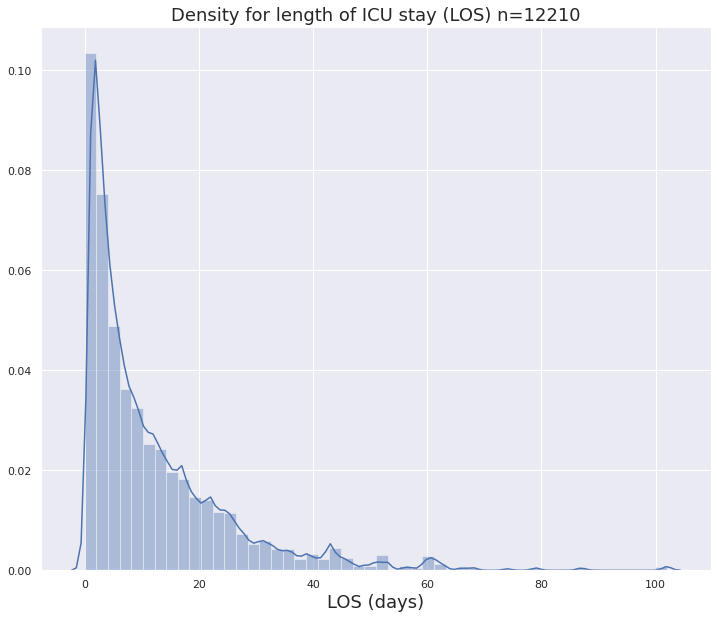

In [0]:
ICUtmp = ICUinputs.copy(deep=True)

display(HTML('<h4>Length of stay in the ICU:</h4>'))
print("LOS minimum:           {}".format(ICUtmp['LOS_ICU_days'].min()))
print("LOS maximum:           {}".format(ICUtmp['LOS_ICU_days'].max()))
print("LOS mean:              {:0.2f} +/- {:0.2f}".format(ICUtmp['LOS_ICU_days'].mean(),ICUtmp['LOS_ICU_days'].std()))
print("LOS median:            {}".format(ICUtmp['LOS_ICU_days'].median()))
print("LOS mode:              {}".format(ICUtmp['LOS_ICU_days'].mode()[0]))
print("LOS frequency of mode: {}".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']==ICUtmp['LOS_ICU_days'].mode()[0],'LOS_ICU_days'])))
print("Percentage of ICU stays that are within the mode: {:0.2f}%".format(
    (len(ICUtmp.loc[ICUtmp['LOS_ICU_days']==ICUtmp['LOS_ICU_days'].mode()[0],
                    'LOS_ICU_days']))/ICUtmp.shape[0]*100) )
print("")
print("Instances less than 1 day:     {}".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']<1,'LOS_ICU_days'])))
print("Percentage of less than 1 day: {:0.2f}%".format(len(ICUtmp.loc[ICUtmp['LOS_ICU_days']<1,
                                                                       'LOS_ICU_days'])/ICUtmp.shape[0]*100))
print("")
print("LOS frequency >=1 day: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=1,'LOS_ICU_days'])))
print("ICU stays in day 1:    {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=1,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days'])))
print("")
print("LOS frequency >=2 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days'])))
print("ICU stays in day 2:     {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=2,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days'])))
print("")
print("LOS frequency >=3 days: {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days'])))
print("ICU stays in day 3:     {}".format(len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=3,'LOS_ICU_days']) - len(ICUtmp.loc[
    ICUtmp['LOS_ICU_days']>=4,'LOS_ICU_days'])))
print("")

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Plot
plt.figure(figsize=(12,10))
plt.title('Density for length of ICU stay (LOS) n='+str(ICUtmp.ICUSTAY_ID.nunique())
          ,fontsize=18)
sns.distplot(ICUtmp.LOS_ICU_days, label="LOS")
plt.xlabel('LOS (days)', fontsize=18)

#### Glucose readings/ICU stays

In [0]:
# Glucose readings/ICU stay

admissions['LOS_ICU_min'] = (admissions['ICU_DISCHARGETIME']-
                             admissions['ICU_ADMISSIONTIME'])/np.timedelta64(1, 'm')

admissions['dischtime'] = pd.to_datetime(admissions['dischtime'], utc=True)

admissions.loc[admissions.index[np.isnan(admissions['LOS_ICU_min'])],
               'LOS_ICU_min'] = (admissions['dischtime']-
                                 admissions['ICU_ADMISSIONTIME'])/np.timedelta64(1, 'm')

def reading_hourICUstay(df):
    # Merge admissions with df
    # Size would reduce because we are removing those outside ICU
    df3 = admissions[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS_ICU_min']].merge(
        df[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','glucose']], 
        how ='inner', on=["SUBJECT_ID","HADM_ID","ICUSTAY_ID"]).sort_values(
        by=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])
    
    # Count glucose readings
    count_glucose = df3.groupby('ICUSTAY_ID').count().glucose
    # Extract LOS
    LOS = df3.groupby('ICUSTAY_ID').mean().LOS_ICU_min
    # Create empty dataframe
    df2 = pd.DataFrame()
    # Divide number of readings/LOS
    df2['read_minICU'] = count_glucose/LOS
    
    return df2

df_read_min_both = reading_hourICUstay(df_both)
df_read_min_finger = reading_hourICUstay(df_finger)
df_read_min_lab = reading_hourICUstay(df_lab)

d = 2;

display(HTML('<h2>Glucose readings per minute per ICU stay<h2>'))
print("Readings per minute in both methods: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_both.read_minICU.mean(),
    df_read_min_both.read_minICU.std(),
    df_read_min_both.read_minICU.mean()*60*d,df_read_min_both.read_minICU.std()*60*d,d))
print("Readings per minute for fingerstick: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_finger.read_minICU.mean(),
    df_read_min_finger.read_minICU.std(),
    df_read_min_finger.read_minICU.mean()*60*d,df_read_min_finger.read_minICU.std()*60*d,d))
print("Readings per minute for lab analyzer: {:0.5f} +/- {:0.5f}, that means {:0.2f} +/- {:0.2f} readings every {} hours".format(
    df_read_min_lab.read_minICU.mean(),
    df_read_min_lab.read_minICU.std(),
    df_read_min_lab.read_minICU.mean()*60*d,df_read_min_lab.read_minICU.std()*60*d,d))

Readings per minute in both methods: 0.00515 +/- 0.00333, that means 0.62 +/- 0.40 readings every 2 hours
Readings per minute for fingerstick: 0.00406 +/- 0.00328, that means 0.49 +/- 0.39 readings every 2 hours
Readings per minute for lab analyzer: 0.00116 +/- 0.00062, that means 0.14 +/- 0.07 readings every 2 hours


Text(0.5, 0, 'Readings/hr')

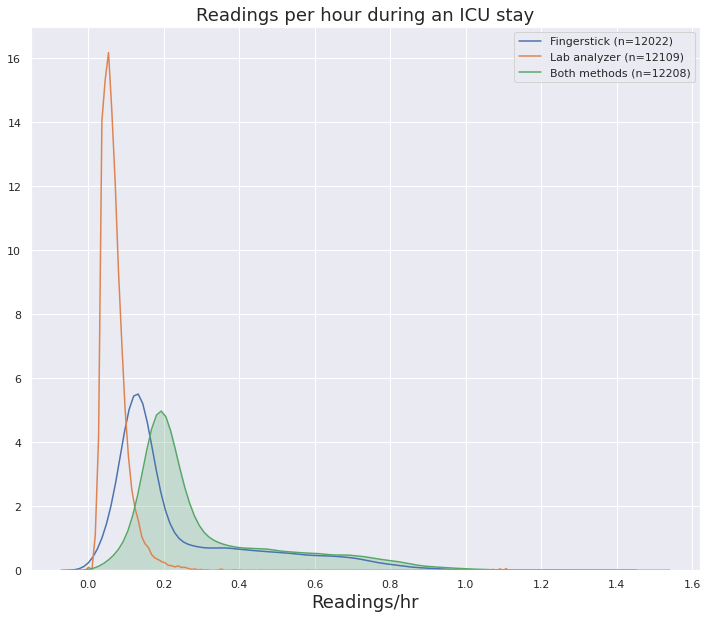

In [0]:
# Plot
plt.figure(figsize=(12,10))
plt.title('Readings per hour during an ICU stay', fontsize=18)
sns.kdeplot(df_read_min_finger.read_minICU*60, shade=False,
             label="Fingerstick (n="+str(df_read_min_finger.shape[0])+")")
sns.kdeplot(df_read_min_lab.read_minICU*60, shade=False,
             label="Lab analyzer (n="+str(df_read_min_lab.shape[0])+")")
sns.kdeplot(df_read_min_both.read_minICU*60, shade=True,
             label="Both methods (n="+str(df_read_min_both.shape[0])+")")
plt.xlabel('Readings/hr', fontsize=18)

## Export to BigQuery

In [0]:
# Exporting to BigQuery the table
# DO NOT RE-RUN or otherwise you will be rewritting
# Same table as glucose_insulin_ICU.csv

# Assign the name for the table
table_ref = dataset_ref.table('glc_cur0ins_cur')
#client.load_table_from_dataframe(ICUinputs, table_ref).result()

del table_ref

# Code - Pairing

## Pairing rules
Once merged the insulin inputs and glucose readings from the *SensitivityAnalysisI.ipynb* notebok, now we continue with the **pairing** of an insulin event with a preceding glucose reading.

The goal is to link each insulin dose with the nearest glucose measurement. For this complex task, the following rules were implemented. This operation is done in BigQuery. The following rules or assumptions are proposed:

1. **Rule 1**: A glucose reading should precede a regular insulin administration by up to 90 minutes. This basis for this time window is derived from the diabetic ketoacidosis guidelines which recommend measuring glucose values every 60 minutes while receiving an insulin infusion. An additional 30 minutes were added, 90 minutes in total, to this interval to account for the time it may take for providers to register the event. 
2. **Rule 2**: When a regular insulin event is not preceded, but instead followed, by a blood glucose measurement, this glucose reading is paired with the regular insulin administration if they are recorded within 90 minutes of each other.
3. **Rule 3**: Sometimes a regular insulin infusion/bolus appears between 2 blood glucose measurements. In this case, the higher glucose value is paired with the regular insulin entry as long as they are entered within 90 minutes of each other.
4. **Rule 4**: When a regular insulin bolus occurs very close to a regular insulin infusion rate, it is assumed that the patient was given a bolus and then commenced on an infusion. Both regular insulin entries are paired with the preceding blood glucose measurement, or the posterior glucose reading in case its value is higher than the preceding blood glucose and is entered within 90 minutes of the insulin dose.
5. No glucose values below 90 mg/dL is paired with a subsequent regular insulin bolus or infusion. No clinician will treat this low of a blood glucose value with a regular insulin bolus or infusion.

### Query

In [0]:
# Import dataset adjusted or aligned
#projectid = "YOUR-PROJECT"

query ="""
WITH pg AS(
    SELECT p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings, select the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLC,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another insulin event
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the POSTERIOR glucose (1 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))

        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLC_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column GLCTIMER_AL that would gather the timestamp of the paired glucose reading
    , (CASE 
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.TIMER,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the timestamp of the POSTERIOR glucose (1 rows below) measurement that gathers the 
        -- previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCTIMER_AL

    -- -----------------------------------------------------------------------------------------------
    -- Column GLCSOURCE_AL that would indicate whether is fingerstick or lab analyzer sample of 
    -- the paired glucose reading
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLCSOURCE,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the whether is figerstick or lab analyzer the POSTERIOR glucose (1 rows below) measurement 
        -- that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCSOURCE_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column RULE that indicateS which pairing rule is applied for the i^th case
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

            -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 3
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN 4

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the Rule number applied
        THEN 2
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS RULE

    FROM `icuinsulintherapy.glc_cur0ins_cur` AS p1
    WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
)

-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*
, (CASE
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LEAD(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          THEN 1 
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LAG(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          AND LAG(endtime,1) OVER(x) IS NOT null 
          THEN 1
          ELSE null END) AS Repeated
FROM pg
WINDOW x AS(PARTITION BY ICUSTAY_ID ORDER BY pg.timer)
"""

ICUinputs_adjusted = q(query,projectid)

del query

# Convert dtypes
ICUinputs_adjusted[["Repeated","INFXSTOP","RULE"]] = ICUinputs_adjusted[
        ["Repeated","INFXSTOP","RULE"]].apply(pd.to_numeric, errors='coerce')

# Remove values that are repeated due to the SQL query
ICUinputs_adjusted = ICUinputs_adjusted[ICUinputs_adjusted['Repeated']!=1]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(ICUinputs_adjusted.shape[0]))
print("Patients: {}".format(ICUinputs_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICUinputs_adjusted['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(ICUinputs_adjusted['RULE'].value_counts())

Entries: 496204
Patients: 9518
Hospital admissions: 11094
ICU stays: 12210


1.0    86903
2.0     8838
4.0     8683
3.0     5588
Name: RULE, dtype: int64


#### Boluses of short-acting insulin

In [0]:
# Filtering for only short insulin boluses and all sources of glucose
short_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(short_BOL_adjusted.shape[0]))
print("Patients:            {}".format(short_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(short_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(short_BOL_adjusted[['INPUT','GLC_AL']].describe())

# Save CSV - Uncomment as needed
#short_BOL_adjusted.to_csv(base_dir+"/DataExtraction/BolusesCUR.csv", index=False, 
#                          encoding='utf8', header = True)

Entries:             88464
Patients:            9370
Hospital admissions: 10877
ICU stays:           11484


,INPUT,GLC_AL
count,88464.000000,71457.000000
mean,4.518060,187.710833
std,3.038464,58.224310
min,0.100000,90.000000
25%,2.000000,150.000000
50%,4.000000,173.000000
75%,6.000000,211.000000
max,17.000000,901.000000


#### Infusions of short-acting insulin

In [0]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
short_INF_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('INFUSION'))].copy()

# Get statistics
display(HTML('<h5>Counts</h5>'))
print("Entries:             {}".format(short_INF_adjusted.shape[0]))
print("Patients:            {}".format(short_INF_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_INF_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(short_INF_adjusted['ICUSTAY_ID'].nunique()))

display(short_INF_adjusted[['INPUT_HRS','GLC_AL']].describe())

Entries:             44631
Patients:            3607
Hospital admissions: 3813
ICU stays:           3859


,INPUT_HRS,GLC_AL
count,44631.000000,34662.000000
mean,4.985731,166.908488
std,4.164922,74.122587
min,0.003418,90.000000
25%,2.000681,122.000000
50%,4.000000,145.000000
75%,6.006279,184.000000
max,29.812108,847.000000


In [0]:
# Aligned and not aligned entries
display(HTML('<h2>Infusions entries of short-acting insulin<h2>'))
print("Entries that were aligned: {}".format(
    short_INF_adjusted.shape[0]-short_INF_adjusted.loc[np.isnan(
        short_INF_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    short_INF_adjusted.loc[np.isnan(short_INF_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage: {:0.2f}%".format(
    short_INF_adjusted.loc[np.isnan(
        short_INF_adjusted.RULE),'RULE'].shape[0]/short_INF_adjusted.shape[0]*100))

Entries that were aligned: 34661
Entries that weren't aligned: 9970
Non-paired percentage: 22.34%


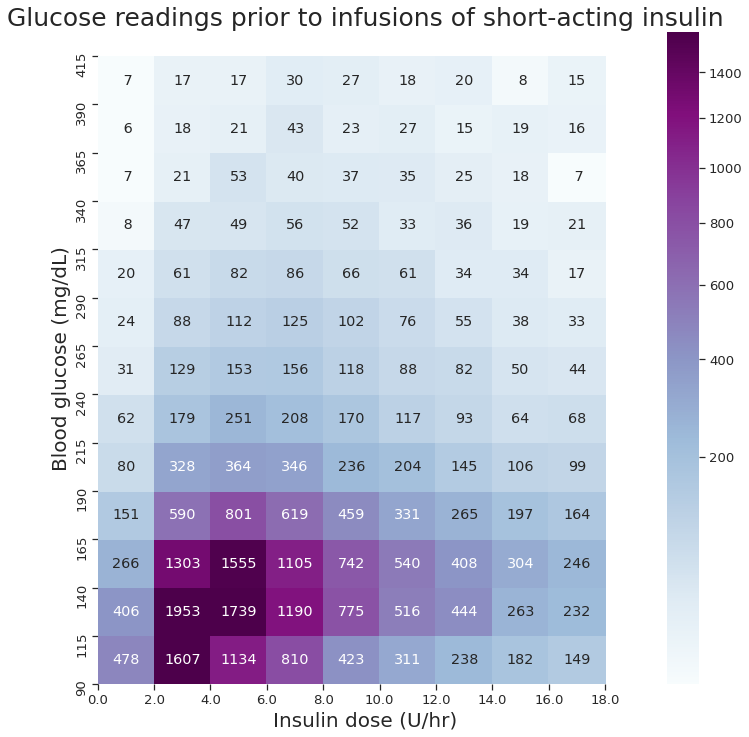

In [0]:
warnings.simplefilter('ignore')

# Heatmap
short_INF_heat = short_INF_adjusted.dropna(subset=['GLC_AL']).copy()
short_INF_heat['A'] = ((short_INF_heat['GLCTIMER_AL'] - 
              short_INF_heat['STARTTIME'])/pd.Timedelta('1 minute'))*60
short_INF_heat=short_INF_heat.set_index('A')

#Define the cell size on the heat map
glc_base=25
ins_base=2

#Define heatmap limits
xlow=0
xhigh=P99_bol_s
ylow=90
yhigh=400
xhigh-=ins_base

#create categories for constructing the heatmap
short_INF_heat['glc_cat']=(short_INF_heat['GLC_AL'].apply(
        lambda x: myround(x, glc_base))/glc_base)
short_INF_heat['ins_cat']=(short_INF_heat['INPUT'].apply(
        lambda x: myround(x, ins_base))/ins_base)

#create dataframe for the heatmap using pivot_table
heat_df_i=pd.pivot_table(short_INF_heat, values='ICUSTAY_ID', index=['glc_cat']
, columns=['ins_cat'], aggfunc='count')
#trim the heatmap dataframe based on the lmits specificed
heat_df_i=heat_df_i.loc[ylow/glc_base:yhigh/glc_base:,xlow/ins_base:xhigh/ins_base:]

#create labels for the x and y ticks
heat_xtick=np.arange(xlow, xhigh+ins_base*2, ins_base)
heat_ytick=np.arange(ylow, yhigh+glc_base*1, glc_base)

#plot heatmap
sns.set(style="ticks", font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax=sns.heatmap(heat_df_i, robust=True, annot=True, cmap="BuPu", fmt="2.0f"
               , xticklabels=heat_xtick, yticklabels=heat_ytick
               , norm=colors.PowerNorm(gamma=1./2.))

#titles
plt.title("Glucose readings prior to infusions of short-acting insulin", fontsize=25)
plt.ylabel("Blood glucose (mg/dL)", fontsize=20)
plt.xlabel("Insulin dose (U/hr)", fontsize=20)

#invert axis and offset labels
ax.invert_yaxis()
ax.set_yticks(np.arange(0, ((yhigh-ylow)/glc_base)+1))
ax.set_xticks(np.arange(0, ((xhigh-xlow)/ins_base)+2))

In [0]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of short-acting insulin<h2>'))
print("Entries that were aligned: {}".format(
    short_BOL_adjusted.shape[0]-short_BOL_adjusted.loc[np.isnan(
        short_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    short_BOL_adjusted.loc[np.isnan(short_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage: {:0.2f}%".format(
    short_BOL_adjusted.loc[np.isnan(
        short_BOL_adjusted.RULE),'RULE'].shape[0]/short_BOL_adjusted.shape[0]*100))

Entries that were aligned: 71455
Entries that weren't aligned: 17009
Non-paired percentage: 19.23%


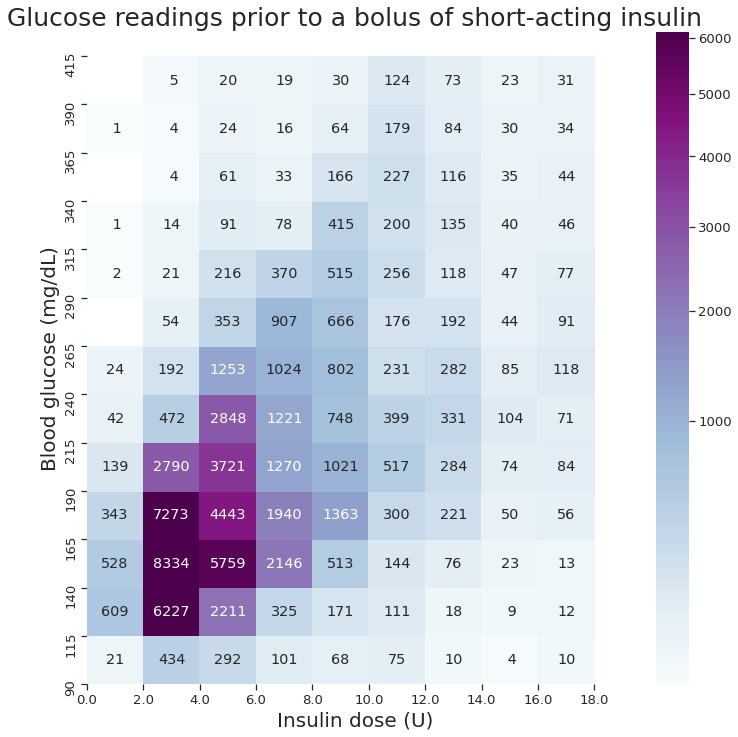

In [0]:
warnings.simplefilter('ignore')

# From Part1 Notebook
P99_bol_s = 18.0

# Heatmap
short_BOL_heat = short_BOL_adjusted.dropna(subset=['GLC_AL']).copy()
short_BOL_heat['A'] = ((short_BOL_heat['GLCTIMER_AL'] - 
              short_BOL_heat['STARTTIME'])/pd.Timedelta('1 minute'))*60
short_BOL_heat=short_BOL_heat.set_index('A')

#Define the cell size on the heat map
glc_base=25
ins_base=2

#Define heatmap limits
xlow=0
xhigh=P99_bol_s
ylow=90
yhigh=400
xhigh-=ins_base

#create categories for constructing the heatmap
short_BOL_heat['glc_cat']=(short_BOL_heat['GLC_AL'].apply(
        lambda x: myround(x, glc_base))/glc_base)
short_BOL_heat['ins_cat']=(short_BOL_heat['INPUT'].apply(
        lambda x: myround(x, ins_base))/ins_base)

#create dataframe for the heatmap using pivot_table
heat_df=pd.pivot_table(short_BOL_heat, values='ICUSTAY_ID', index=['glc_cat']
, columns=['ins_cat'], aggfunc='count')
#trim the heatmap dataframe based on the lmits specificed
heat_df=heat_df.loc[ylow/glc_base:yhigh/glc_base:,xlow/ins_base:xhigh/ins_base:]

#create labels for the x and y ticks
heat_xtick=np.arange(xlow, xhigh+ins_base*2, ins_base)
heat_ytick=np.arange(ylow, yhigh+glc_base*1, glc_base)

#plot heatmap
sns.set(style="ticks", font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax=sns.heatmap(heat_df, robust=True, annot=True, cmap="BuPu", fmt="2.0f"
               , xticklabels=heat_xtick, yticklabels=heat_ytick
               , norm=colors.PowerNorm(gamma=1./2.))

#titles
plt.title("Glucose readings prior to a bolus of short-acting insulin", 
          fontsize=25)
plt.ylabel("Blood glucose (mg/dL)", fontsize=20)
plt.xlabel("Insulin dose (U)", fontsize=20)

#invert axis and offset labels
ax.invert_yaxis()
ax.set_yticks(np.arange(0, ((yhigh-ylow)/glc_base)+1))
ax.set_xticks(np.arange(0, ((xhigh-xlow)/ins_base)+2))
fig.savefig(base_dir+'/DataExtraction/ShortBolusHeatMap.png', bbox_inches='tight',
            dpi=fig.dpi)

#### Boluses of intermediate-acting insulin

In [0]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
inter_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Intermediate") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Counts</h5>'))
print("Entries:             {}".format(inter_BOL_adjusted.shape[0]))
print("Patients:            {}".format(inter_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(inter_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(inter_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(inter_BOL_adjusted[['INPUT','GLC_AL']].describe())

Entries:             3962
Patients:            680
Hospital admissions: 781
ICU stays:           813


,INPUT,GLC_AL
count,3962.000000,971.000000
mean,18.572438,172.649846
std,15.330288,66.466556
min,1.000000,90.000000
25%,8.000000,126.500000
50%,15.000000,151.000000
75%,25.000000,202.000000
max,180.000000,481.000000


In [0]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of intermediate-acting insulin<h2>'))
print("Entries that were aligned:    {}".format(
    inter_BOL_adjusted.shape[0]-inter_BOL_adjusted.loc[np.isnan(
        inter_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    inter_BOL_adjusted.loc[np.isnan(inter_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage:        {:0.2f}%".format(
    inter_BOL_adjusted.loc[np.isnan(
        inter_BOL_adjusted.RULE),'RULE'].shape[0]/inter_BOL_adjusted.shape[0]*100))

Entries that were aligned:    964
Entries that weren't aligned: 2998
Non-paired percentage:        75.67%


#### Boluses of long-acting insulin

In [0]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
long_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Long") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(long_BOL_adjusted.shape[0]))
print("Patients:            {}".format(long_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(long_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(long_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(long_BOL_adjusted[['INPUT','GLC_AL']].describe())

Entries:             8626
Patients:            2908
Hospital admissions: 3314
ICU stays:           3408


,INPUT,GLC_AL
count,8626.000000,2960.000000
mean,23.382460,153.597297
std,16.148415,64.966786
min,1.000000,90.000000
25%,10.000000,111.000000
50%,20.000000,130.000000
75%,30.000000,175.000000
max,180.000000,543.000000


In [0]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of long-acting insulin<h2>'))
print("Entries that were aligned:    {}".format(
    long_BOL_adjusted.shape[0]-long_BOL_adjusted.loc[np.isnan(
        long_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    long_BOL_adjusted.loc[np.isnan(long_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage:        {:0.2f}%".format(
    long_BOL_adjusted.loc[np.isnan(
        long_BOL_adjusted.RULE),'RULE'].shape[0]/long_BOL_adjusted.shape[0]*100))

Entries that were aligned:    2932
Entries that weren't aligned: 5694
Non-paired percentage:        66.01%


## Non-adjusted datasets
To complement this analysis, and to show the difference between implementing and not implementing the proposed rules, three cohorts were created: a) no pairing rules applied, b) paired a glucose reading recorded within 60 minutes of the insulin event instead of 90 minutes, and c) pairing a glucose reading.

### Scenario C
Glucose readings CURATED and insulin inputs CURATED but NO RULES

In [0]:
# GLUCOSE READINGS CURATED AND INSULIN INPUTS CURATED but no RULES
#projectid = "YOUR-PROJECT"

query = """
SELECT pg.*
        , (CASE
                WHEN pg.GLCSOURCE_AL IS null 
                AND (LEAD(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.ICUSTAY_ID ORDER BY pg.TIMER) = pg.GLCTIMER)
                THEN 1 
                WHEN pg.GLCSOURCE_AL IS null 
                AND (LAG(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.ICUSTAY_ID ORDER BY pg.timer) = pg.GLCTIMER)
                AND LAG(endtime,1) OVER(PARTITION BY ICUSTAY_ID ORDER BY timer) IS NOT null 
                THEN 1
                ELSE null END) AS Repeated
        FROM(SELECT p1.* 
        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.GLC,1) OVER(w))
            ELSE null END
            ) AS GLC_AL

        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.TIMER,1) OVER(w))
            ELSE null END
            ) AS GLCTIMER_AL

        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.GLCSOURCE,1) OVER(w))
            ELSE null END
            ) AS GLCSOURCE_AL
        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN 1
            ELSE null END
            ) AS RULE
        FROM `icuinsulintherapy.glc_cur0ins_cur` AS p1
        WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
        ) AS pg
"""

glc_curALins_cur = q(query,projectid)

qwe = glc_curALins_cur[(glc_curALins_cur['INSULINTYPE']=="Short") & 
        (glc_curALins_cur['EVENT'].str.contains('BOLUS'))].copy()

display(HTML('<h4>Statistics for both glucose readings and insulin inputs CURATED</h4>'))
print("Total entries: {}".format(glc_curALins_cur.shape[0]))
display(qwe[['INPUT','GLC_AL']].describe())

display(HTML('<h5>Contains the following information (only for short-acting)</h5>'))
print("Boluses of short-acting insulin: {}".format(qwe.shape[0]))
print("Patients: {} out of {}".format(qwe['SUBJECT_ID'].nunique(),
                                      glc_curALins_cur['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(qwe['HADM_ID'].nunique()))
print('ICU stays: {}'.format(qwe['ICUSTAY_ID'].nunique()))

qwe.to_csv(base_dir+"/DataExtraction/BolusesCUR_nr.csv", index=False,
           encoding='utf8', header = True)

del query,qwe

/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 35090), raddr=('74.125.142.95', 443)>
  obj, end = self.scan_once(s, idx)
/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 37926), raddr=('74.125.195.95', 443)>
  obj, end = self.scan_once(s, idx)


Total entries: 603767


,INPUT,GLC_AL
count,88464.000000,78881.000000
mean,4.518060,183.009571
std,3.038464,58.253377
min,0.100000,2.000000
25%,2.000000,145.000000
50%,4.000000,169.000000
75%,6.000000,207.000000
max,17.000000,901.000000


Boluses of short-acting insulin: 88464
Patients: 9370 out of 9518
Hospital admissions: 10877
ICU stays: 11484


### Scenario B
Glucose reading CURATED and inulin inputs CURATED paired with rules (60 min)

In [0]:
# Import dataset adjusted or aligned with 60 min
#projectid = "YOUR-PROJECT"

query ="""
WITH pg AS(
    SELECT p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings, select the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLC,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another insulin event
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the POSTERIOR glucose (1 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))

        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLC_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column GLCTIMER_AL that would gather the timestamp of the paired glucose reading
    , (CASE 
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.TIMER,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the timestamp of the POSTERIOR glucose (1 rows below) measurement that gathers the 
        -- previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCTIMER_AL

    -- -----------------------------------------------------------------------------------------------
    -- Column GLCSOURCE_AL that would indicate whether is fingerstick or lab analyzer sample of 
    -- the paired glucose reading
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLCSOURCE,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the whether is figerstick or lab analyzer the POSTERIOR glucose (1 rows below) measurement 
        -- that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCSOURCE_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column RULE that indicateS which pairing rule is applied for the i^th case
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

            -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 3
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN 4

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the Rule number applied
        THEN 2
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS RULE

    FROM `icuinsulintherapy.glc_cur0ins_cur` AS p1
    WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
)

-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*
, (CASE
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LEAD(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          THEN 1 
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LAG(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          AND LAG(endtime,1) OVER(x) IS NOT null 
          THEN 1
          ELSE null END) AS Repeated
FROM pg
WINDOW x AS(PARTITION BY ICUSTAY_ID ORDER BY pg.timer)
"""

ICU60min_adjusted = q(query,projectid)

del query

# Convert dtypes
ICU60min_adjusted[["Repeated","INFXSTOP","RULE"]] = ICU60min_adjusted[
        ["Repeated","INFXSTOP","RULE"]].apply(pd.to_numeric, errors='coerce')

# Remove values that are repeated due to the SQL query
ICU60min_adjusted = ICU60min_adjusted[ICU60min_adjusted['Repeated']!=1]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(ICU60min_adjusted.shape[0]))
print("Patients: {}".format(ICU60min_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICU60min_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICU60min_adjusted['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(ICU60min_adjusted['RULE'].value_counts())

/usr/local/lib/python3.6/dist-packages/pandas/core/common.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 36570), raddr=('74.125.142.95', 443)>
  value = tslibs.Timestamp(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/common.py:89: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 36568), raddr=('74.125.142.95', 443)>
  value = tslibs.Timestamp(value)


Entries: 504340
Patients: 9518
Hospital admissions: 11094
ICU stays: 12210


1.0    80159
2.0     8541
4.0     7932
3.0     4642
Name: RULE, dtype: int64


#### Boluses of short-acting insulin

In [0]:
# Filtering for only short insulin boluses and all sources of glucose
short_BOL_60 = ICU60min_adjusted[(ICU60min_adjusted['INSULINTYPE']=="Short") & 
                                 (ICU60min_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(short_BOL_60.shape[0]))
print("Patients: {}".format(short_BOL_60['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_BOL_60['HADM_ID'].nunique()))
print('ICU stays: {}'.format(short_BOL_60['ICUSTAY_ID'].nunique()))

display(short_BOL_60[['INPUT','GLC_AL']].describe())

# Save to CSV - Uncomment as needed
#short_BOL_60.to_csv(base_dir+"/DataExtraction/BolusesCUR_60.csv", index=False,
#                    encoding='utf8', header = True)

Entries: 88464
Patients: 9370
Hospital admissions: 10877
ICU stays: 11484


,INPUT,GLC_AL
count,88464.000000,64925.000000
mean,4.518060,187.689781
std,3.038464,58.144690
min,0.100000,90.000000
25%,2.000000,150.000000
50%,4.000000,173.000000
75%,6.000000,211.000000
max,17.000000,901.000000


**END**